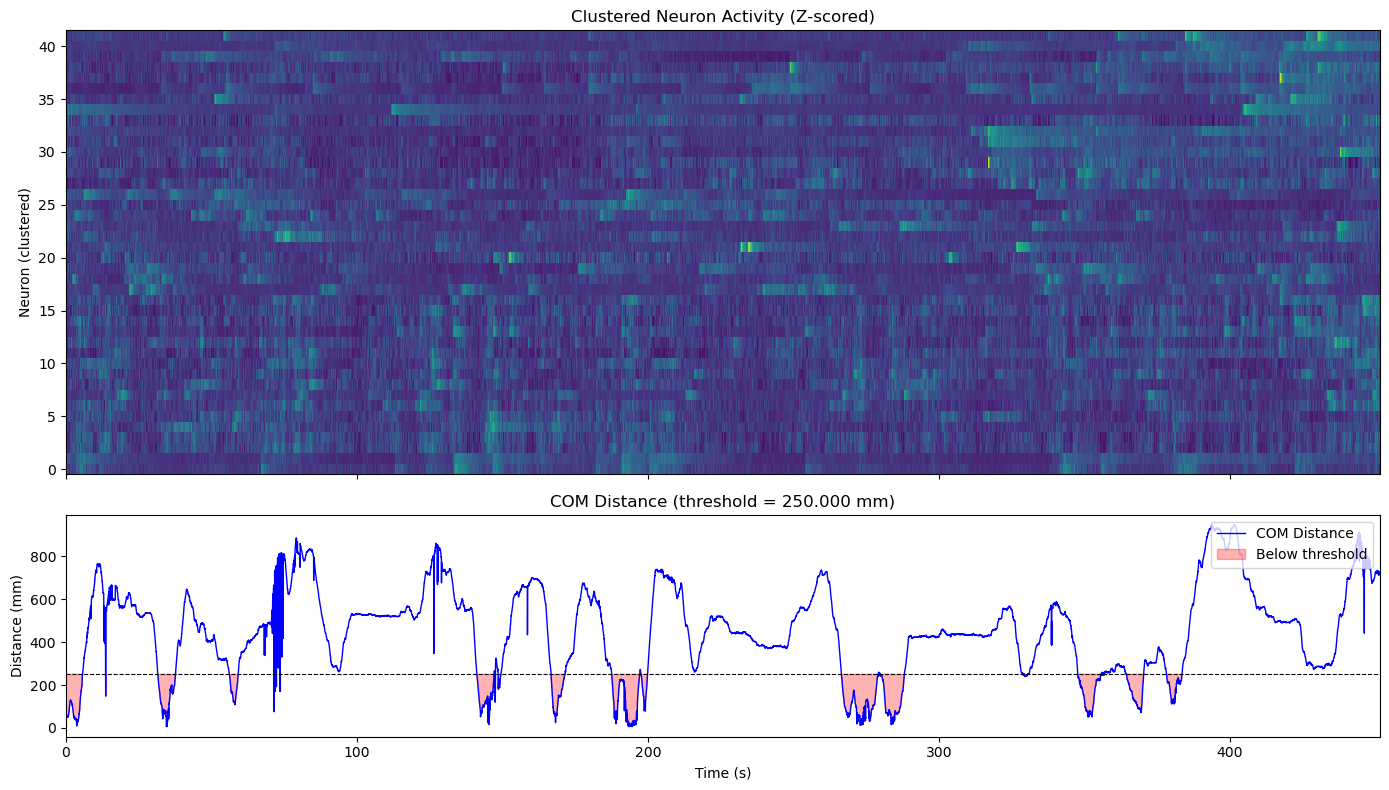

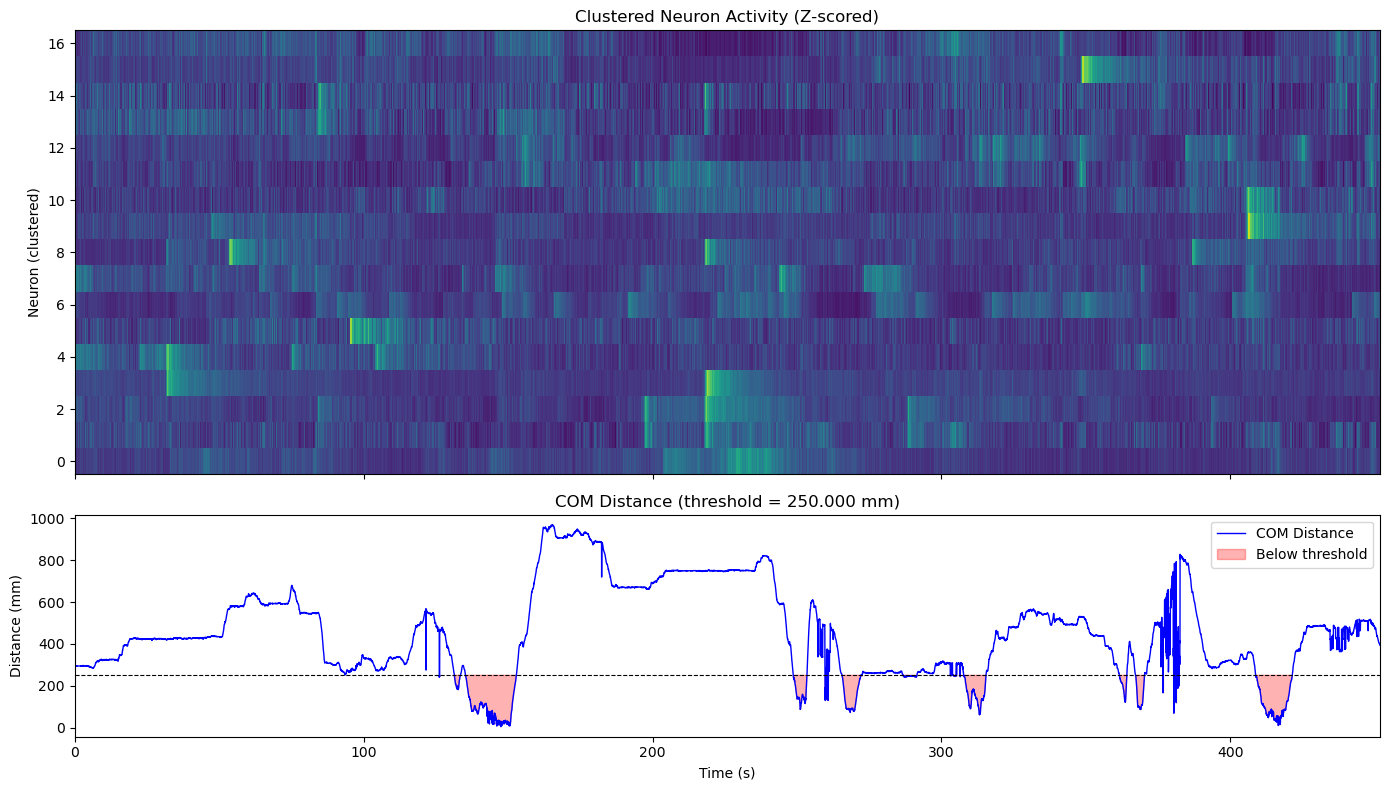

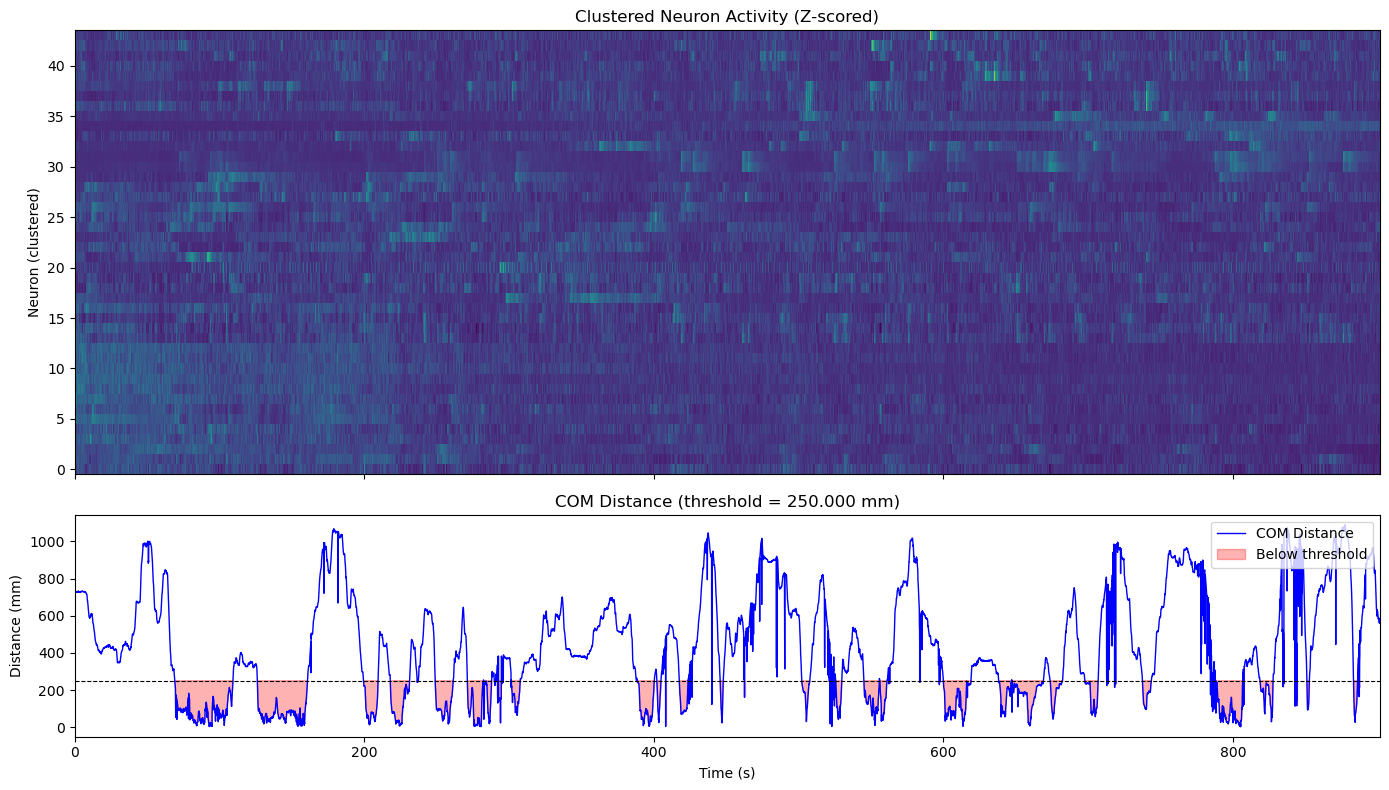

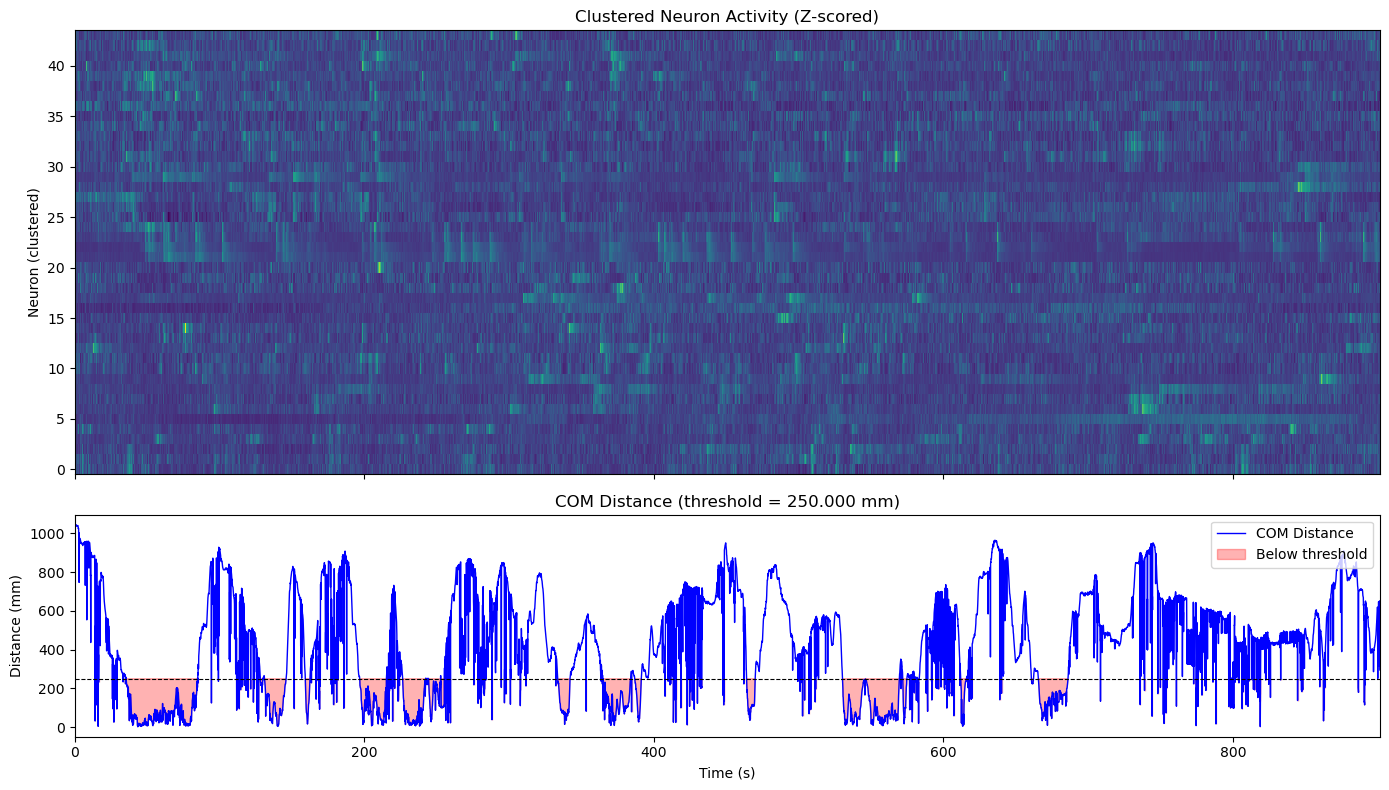

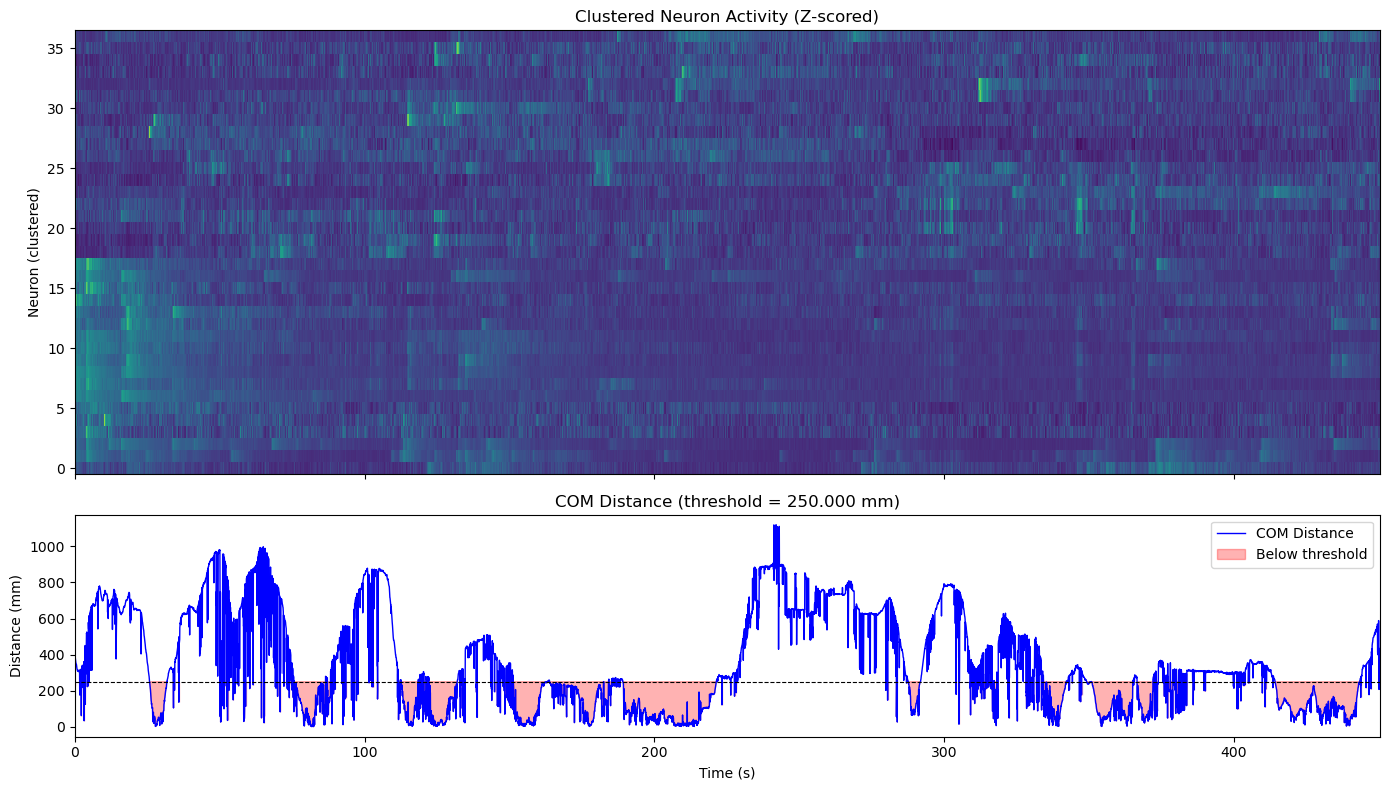

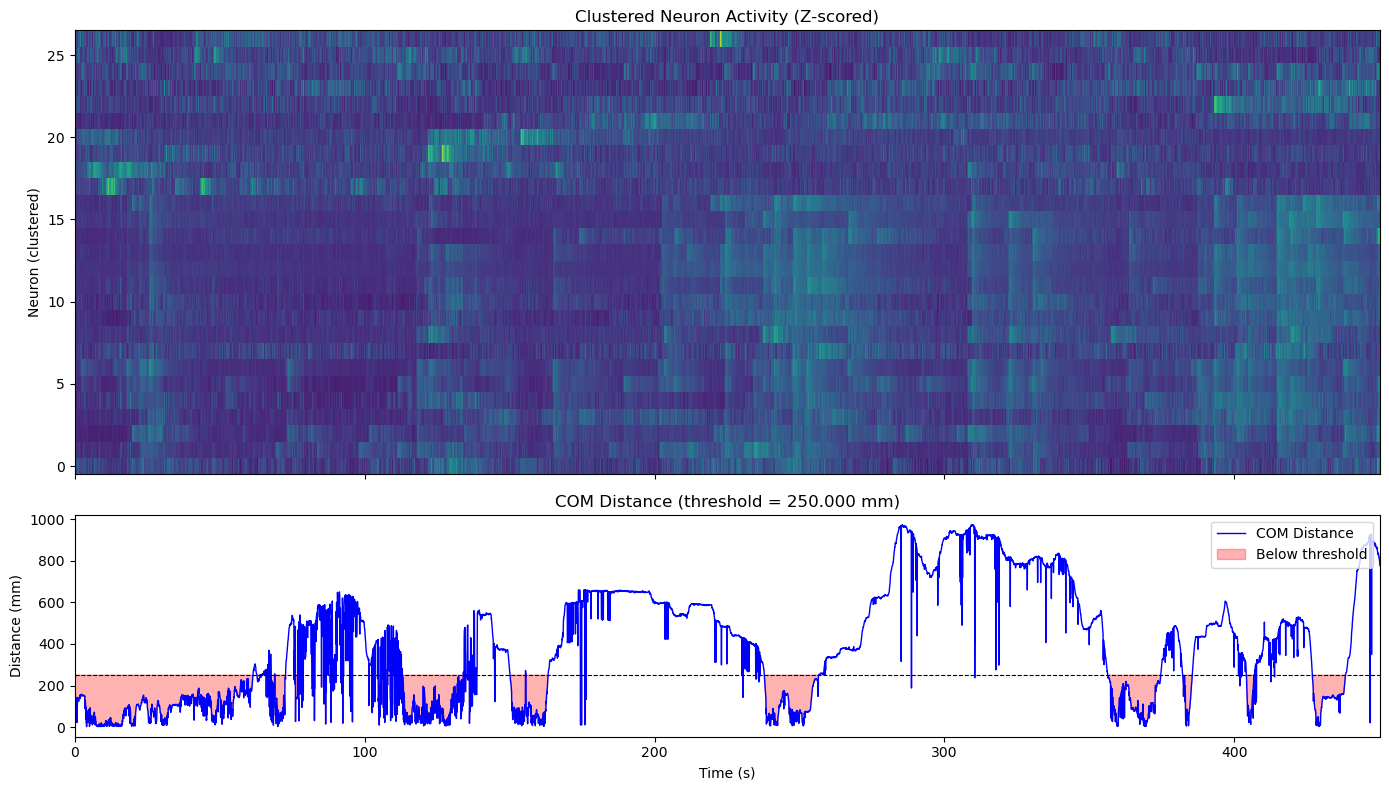

In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')

    # 在这里先不重置 index，因为后续 process_neuron_activity 会返回 df_reset
    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    过滤低方差神经元、排除指定索引，并对剩余神经元的 dF/F 序列进行 z-score 标准化。
    返回：
      - normalized: 形状为 (n_kept_neurons, n_timepoints) 的 numpy 数组
      - filtered_cols: 保留下来的列名列表
      - df_reset: 重置了索引的 DataFrame 副本
    """
    # 先重置索引，确保后续按行筛选时不会丢失列
    df_reset = df.reset_index(drop=True)

    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df_reset['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df_reset.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df_reset[neuron_cols].values.T  # shape: (n_neurons, n_timepoints)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)         # 去掉最底部 5% 方差的神经元
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)

    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine（手动设置阈值，优先尝试 com_distances.csv，不存在时仅根据 com_distances_filtered.csv 高亮）
# ---------------------------------------------------------------------------
def plot_cluster_and_distance(df, distance_threshold, exclude_dict=None,
                              manual_exclude_indices=None, apply_exclusion=True):
    """
    绘制：
      1. 聚类后的神经元活动热图（仅保留高方差、不在排除列表的神经元，Z-score 标准化后层次聚类）。
      2. 如果存在 com_distances.csv，加载并绘制原始 COM 距离曲线（单位：秒），并在低于 distance_threshold 时高亮；
         如果 com_distances.csv 缺失但存在 com_distances_filtered.csv，则仅高亮过滤后的帧对应时间。
    参数：
      - df: HDF5 读取后带有 'camera_frame_sixcam' 和 'timestamp_ms_mini' 的 DataFrame
      - distance_threshold: 手动指定的距离阈值（单位与 CSV 一致，比如 mm）
      - exclude_dict: 排除字典，用于 process_neuron_activity
      - manual_exclude_indices: 手动指定排除的 ROI 索引列表
      - apply_exclusion: 是否应用排除逻辑（True/False）
    要求：
      - com_distances.csv 或 com_distances_filtered.csv 必须存在于 rec_path/MIR_Aligned
      - com_distances.csv 如果存在，需包含 'frame' 与 'distance' 两列
      - com_distances_filtered.csv 需包含 'frame' 列
      - HDF5 必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列
    """
    # 第一步：处理神经元活动，得到标准化矩阵和 df_reset
    neuron_norm, neuron_cols, df_reset = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    rec_path = df_reset['session_path'].iloc[0]
    aligned_dir = os.path.join(rec_path, 'MIR_Aligned')
    df_reset = df.reset_index()

    # 检查 HDF5 中是否存在时间列和帧列
    if 'camera_frame_sixcam' not in df_reset.columns or 'timestamp_ms_mini' not in df_reset.columns:
        raise KeyError("HDF5 数据中必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列")
    df_time_map = df_reset[['camera_frame_sixcam', 'timestamp_ms_mini']].drop_duplicates()

    # 尝试加载 com_distances.csv
    com_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
    has_full = os.path.exists(com_csv)

    if has_full:
        # 如果存在 com_distances.csv，则加载并合并时间映射
        df_com = pd.read_csv(com_csv)
        if 'frame' not in df_com.columns or 'distance' not in df_com.columns:
            raise KeyError("com_distances.csv 中必须包含 'frame' 和 'distance' 两列")
        df_com_merged = pd.merge(
            df_com,
            df_time_map,
            left_on='frame',
            right_on='camera_frame_sixcam',
            how='inner'
        )
        # 原始时间（ms）和距离
        times_all_ms = df_com_merged['timestamp_ms_mini'].values
        distances_raw = df_com_merged['distance'].values
        frames_all = df_com_merged['frame'].values.astype(int)

        # 将时间换算成秒
        time_all_s = times_all_ms / 1000.0

        # 根据手动阈值筛选低于阈值的部分
        below_thresh = (distances_raw <= distance_threshold)
        filtered_frames = frames_all[below_thresh]

    else:
        # 如果没有 com_distances.csv，改为检查 com_distances_filtered.csv
        filtered_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
        if not os.path.exists(filtered_csv):
            raise FileNotFoundError(
                f"Cannot find com_distances.csv or com_distances_filtered.csv in {aligned_dir}"
            )
        df_filtered = pd.read_csv(filtered_csv)
        frame_col = df_filtered.columns[0]
        filtered_frames = df_filtered[frame_col].astype(int).values

        # 时间和距离数据无法获取，只占位
        time_all_s = np.array([])
        distances_raw = np.array([])
        below_thresh = np.array([])

    # 在 df_reset 中标记哪些时间点属于低于阈值（或过滤后）的帧
    mask = df_reset['camera_frame_sixcam'].isin(filtered_frames)
    times_mask_ms = df_reset['timestamp_ms_mini'].values
    times_mask_s = times_mask_ms / 1000.0

    # 开始绘图
    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # 热图：层次聚类后的 neuron_norm
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]
        ax_heatmap.pcolormesh(
            times_mask_s if len(times_mask_s)>0 else np.arange(data_ordered.shape[1]),
            np.arange(data_ordered.shape[0]),
            data_ordered,
            cmap='viridis',
            shading='auto'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    else:
        ax_heatmap.text(
            0.5, 0.5, 'No neuron data after filtering',
            transform=ax_heatmap.transAxes, ha='center'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # 第二个子图：COM 距离随时间变化，并在低于阈值时高亮
    if has_full:
        ax_dist.plot(
            time_all_s,
            distances_raw,
            color='blue',
            linewidth=1,
            label='COM Distance'
        )
        ax_dist.set_ylabel('Distance (mm)')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(f'COM Distance (threshold = {distance_threshold:.3f} mm)')

        # 标出低于阈值的部分
        ax_dist.fill_between(
            time_all_s,
            distances_raw,
            distance_threshold,
            where=(distances_raw <= distance_threshold),
            color='red',
            alpha=0.3,
            label='Below threshold'
        )
        # 画出阈值线
        ax_dist.axhline(distance_threshold, color='black', linestyle='--', linewidth=0.8)
        ax_dist.legend(loc='upper right')

    else:
        # 仅存在 filtered CSV 的情况：画一个空白轴，只高亮过滤帧对应时间
        ax_dist.set_ylabel('Below-Threshold Frames')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(
            'Filtered Frames Highlighted (no full COM distance available)'
        )
        if len(times_mask_s) > 0:
            ax_dist.fill_between(
                times_mask_s,
                0, 1,
                where=mask,
                color='red',
                alpha=0.3,
                transform=ax_dist.get_xaxis_transform()
            )
        ax_dist.set_ylim(0, 1)

    plt.tight_layout()
    plt.show(fig)




# ----------------------------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------------------------
session_paths = [
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48"


    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
]

# 手动指定阈值，例如 250
threshold_value = 250

for path in session_paths:
    try:
        df_session = load_session_data(path)
        plot_cluster_and_distance(
            df_session,
            distance_threshold=threshold_value,
            exclude_dict=exclude_dict,
            apply_exclusion=True
        )
    except Exception as e:
        print(f"Failed for session {path}: {e}")


Failed for session /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48: Dimensions of C (44, 8954) should be one smaller than X(8954) and Y(45) while using shading='flat' see help(pcolormesh)


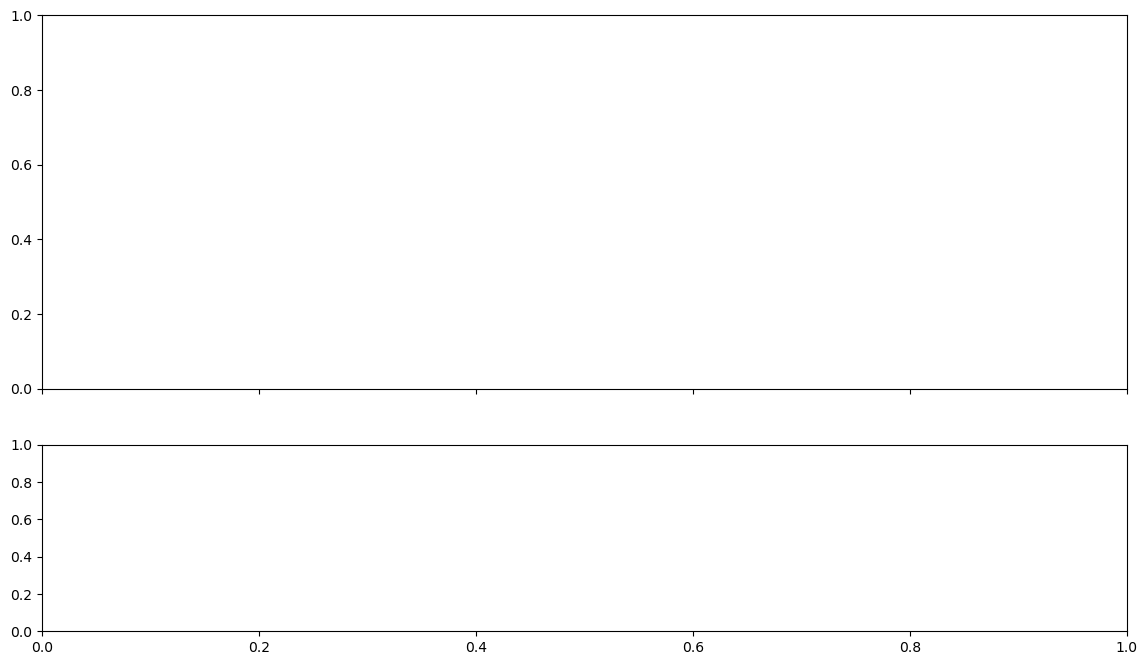

In [26]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')

    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    过滤低方差神经元、排除指定索引，并对剩余神经元的 dF/F 序列进行 z-score 标准化。
    返回：
      - normalized: 形状为 (n_kept_neurons, n_timepoints) 的 numpy 数组
      - filtered_cols: 保留下来的列名列表
      - df_reset: 重置了索引的 DataFrame 副本
    """
    df_reset = df.reset_index(drop=True)

    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df_reset['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df_reset.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df_reset[neuron_cols].values.T  # shape: (n_neurons, n_timepoints)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)         # 去掉最底部 5% 方差的神经元
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)

    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine：在热图上高亮低于阈值的时间段
# ----------------------------------------------------------------------------
def plot_cluster_and_distance(df, distance_threshold, exclude_dict=None,
                              manual_exclude_indices=None, apply_exclusion=True):
    """
    绘制：
      1. 聚类后的神经元活动热图（仅保留高方差、不在排除列表的神经元，Z-score 标准化后层次聚类）；
         并在热图上用半透明红色高亮距离低于阈值的时间段。
      2. 如果存在 com_distances.csv，加载并绘制原始 COM 距离曲线（单位：秒），并在低于 distance_threshold 时高亮；
         如果 com_distances.csv 缺失但存在 com_distances_filtered.csv，则仅高亮过滤后的帧对应时间。
    参数：
      - df: HDF5 读取后带有 'camera_frame_sixcam' 和 'timestamp_ms_mini' 的 DataFrame
      - distance_threshold: 手动指定的距离阈值（单位与 CSV 一致，比如 mm）
      - exclude_dict: 排除字典，用于 process_neuron_activity
      - manual_exclude_indices: 手动指定排除的 ROI 索引列表
      - apply_exclusion: 是否应用排除逻辑（True/False）
    要求：
      - com_distances.csv 或 com_distances_filtered.csv 必须存在于 rec_path/MIR_Aligned
      - com_distances.csv 如果存在，需包含 'frame' 与 'distance' 两列
      - com_distances_filtered.csv 需包含 'frame' 列
      - HDF5 必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列
    """
    # 第一步：处理神经元活动，得到标准化矩阵和 df_reset
    neuron_norm, neuron_cols, df_reset = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    rec_path = df_reset['session_path'].iloc[0]
    aligned_dir = os.path.join(rec_path, 'MIR_Aligned')
    df_reset = df_reset.reset_index(drop=True)

    # 检查 HDF5 中是否存在时间列和帧列
    df_reset = df.reset_index()

    # 尝试加载 com_distances.csv
    full_csv = os.path.join(aligned_dir, 'com_distances.csv')
    filtered_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
    has_full = os.path.exists(full_csv)

    if has_full:
        # 如果存在 com_distances.csv，则加载并合并时间映射
        df_com = pd.read_csv(full_csv)
        if 'frame' not in df_com.columns or 'distance' not in df_com.columns:
            raise KeyError("com_distances.csv 中必须包含 'frame' 和 'distance' 两列")
        df_com_merged = pd.merge(
            df_com,
            df_time_map,
            left_on='frame',
            right_on='camera_frame_sixcam',
            how='inner'
        )
        times_all_ms = df_reset['timestamp_ms_mini'].values
        distances_raw = df_com_merged['distance'].values
        frames_all = df_com_merged['frame'].values.astype(int)
        time_all_s = times_all_ms / 1000.0
        below_thresh = (distances_raw <= distance_threshold)
        filtered_frames = frames_all[below_thresh]

    else:
        # 如果没有 com_distances.csv，检查 com_distances_filtered.csv
        if not os.path.exists(filtered_csv):
            raise FileNotFoundError(
                f"Cannot find com_distances.csv or com_distances_filtered.csv in {aligned_dir}"
            )
        df_filtered = pd.read_csv(filtered_csv)
        frame_col = df_filtered.columns[0]
        filtered_frames = df_filtered[frame_col].astype(int).values
        time_all_s = np.array([])
        distances_raw = np.array([])
        below_thresh = np.array([])

    # 构建完整时间轴与 mask
    # time_full_s：每个样本点对应的秒数（HDF5 中的 timestamp_ms_mini / 1000）
    time_full_s = df_reset['timestamp_ms_mini'].values / 1000.0
    # mask_full：每个样本点是否属于低于阈值的帧
    mask_full = df_reset['camera_frame_sixcam'].isin(filtered_frames).values

    # 开始绘图
    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # ——（一）热图：层次聚类后的 neuron_norm，并在热图上高亮低于阈值的时段
    if neuron_norm.size:
        # 层次聚类
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]

        # 绘制热图，横轴使用完整时间轴
        mesh = ax_heatmap.pcolormesh(
            time_full_s,
            np.arange(data_ordered.shape[0] + 1),  # +1 使得行数对齐
            data_ordered,
            cmap='viridis',
            shading='auto'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')

        # 在热图上叠加低于阈值的半透明红色条带
        # y 从 0 到 n_neurons
        n_neurons = data_ordered.shape[0]
        ax_heatmap.fill_between(
            time_full_s,
            0,
            n_neurons,
            where=mask_full,
            color='red',
            alpha=0.2,
            transform=ax_heatmap.get_xaxis_transform()
        )
    else:
        ax_heatmap.text(
            0.5, 0.5, 'No neuron data after filtering',
            transform=ax_heatmap.transAxes, ha='center'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # ——（二）COM 距离随时间变化，并在低于阈值时高亮
    if has_full:
        ax_dist.plot(
            time_all_s,
            distances_raw,
            color='blue',
            linewidth=1,
            label='COM Distance'
        )
        ax_dist.set_ylabel('Distance (mm)')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(f'COM Distance (threshold = {distance_threshold:.3f} mm)')

        # 标出低于阈值的部分
        ax_dist.fill_between(
            time_all_s,
            distances_raw,
            distance_threshold,
            where=(distances_raw <= distance_threshold),
            color='red',
            alpha=0.3,
            label='Below threshold'
        )
        # 画出阈值线
        ax_dist.axhline(distance_threshold, color='black', linestyle='--', linewidth=0.8)
        ax_dist.legend(loc='upper right')

    else:
        ax_dist.set_ylabel('Below-Threshold Frames')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(
            'Filtered Frames Highlighted (no full COM distance available)'
        )
        if mask_full.any():
            ax_dist.fill_between(
                time_full_s,
                0, 1,
                where=mask_full,
                color='red',
                alpha=0.3,
                transform=ax_dist.get_xaxis_transform()
            )
        ax_dist.set_ylim(0, 1)

    plt.tight_layout()
    plt.show(fig)

# ----------------------------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------------------------
session_paths = [
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48"
]

# 手动指定阈值，例如 250
threshold_value = 250

for path in session_paths:
    try:
        df_session = load_session_data(path)
        plot_cluster_and_distance(
            df_session,
            distance_threshold=threshold_value,
            exclude_dict=exclude_dict,
            apply_exclusion=True
        )
    except Exception as e:
        print(f"Failed for session {path}: {e}")


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1m

/tmp/ipykernel_1307841/2280897917.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


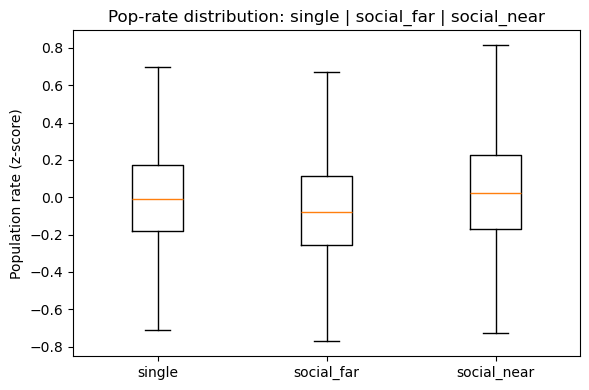

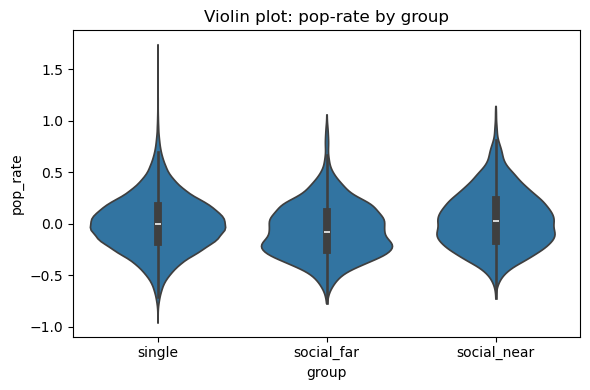

Kruskal–Wallis H = 358.683, p = 1.297e-78
  single vs social_far → U = 182983561.0, p = 1.810e-55
  single vs social_near → U = 226221558.0, p = 1.195e-21
  social_far vs social_near → U = 11894179.0, p = 1.751e-76

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33:


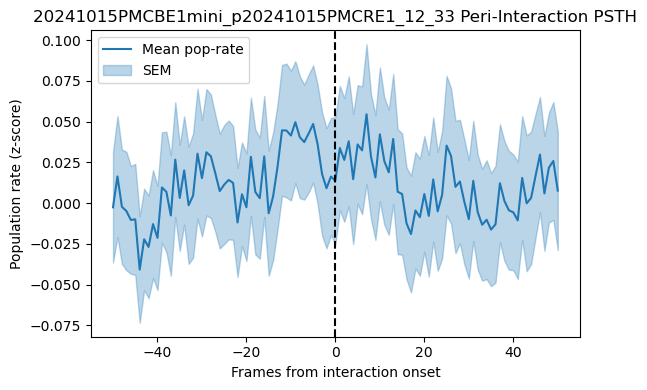


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1:


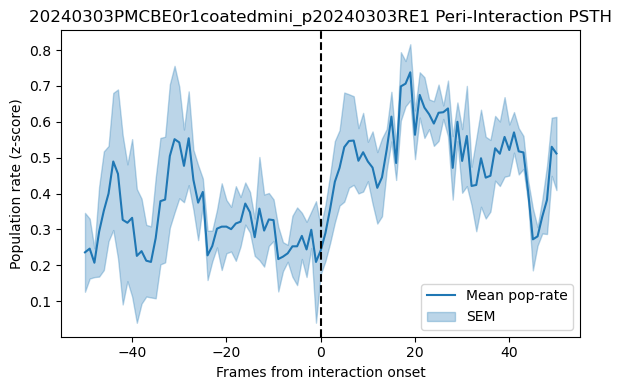


Analysis complete.


In [19]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3. Process and aggregate "social" vs "single" sessions using CSV + manual threshold
# ----------------------------------------------------------------------------
def collect_groups(session_paths, distance_threshold=250.0):
    """
    Given a list of session_paths, determine for each whether it is social (>=2 COM prefixes) or single ('com_x' exists).
    For social sessions, load 'com_distances_filtered.csv', which must contain at least two columns:
      - A frame index column (e.g. 'camera_frame_sixcam')
      - A distance column (e.g. 'distance')
    Use distance_threshold (e.g., 250.0) to split frames into 'social near' (distance <= threshold) vs 'social far'.

    Collect pop_rate into:
      - all_pop_single
      - all_pop_social_near
      - all_pop_social_far

    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single      = []
    all_pop_social_near = []
    all_pop_social_far  = []
    social_onsets_dict  = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Determine session type by checking for COM prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        is_social = len(com_prefixes) >= 2
        is_single = all(k in df_new.columns for k in ['com_x', 'com_y', 'com_z'])

        if is_social:
            # Load filtered distances CSV
            com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
            if not os.path.exists(com_csv_path):
                print(f"  Skipping (social): Missing {com_csv_path}")
                continue

            df_com = pd.read_csv(com_csv_path)
            if df_com.shape[1] < 2:
                raise KeyError(
                    "com_distances_filtered.csv must contain at least two columns: "
                    "frame index (e.g. 'camera_frame_sixcam') and 'distance'."
                )

            # Assume first column is frame index, second column is distance
            frame_col = df_com.columns[0]
            dist_col  = df_com.columns[1]
            df_com[frame_col] = df_com[frame_col].astype(int)
            df_com[dist_col]  = df_com[dist_col].astype(float)

            # Ensure 'camera_frame_sixcam' exists in HDF5
            if 'camera_frame_sixcam' not in df_new.columns:
                print(f"  Skipping (social): Missing 'camera_frame_sixcam' in HDF5")
                continue

            # Merge HDF5 rows with CSV distances by frame index
            merged = pd.merge(
                df_new[['camera_frame_sixcam', 'timestamp_ms_mini']].reset_index(drop=True),
                df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
                on='camera_frame_sixcam',
                how='left'
            )
            # 'merged' now has columns ['camera_frame_sixcam', 'timestamp_ms_mini', 'distance']
            # Frames without a match in CSV get NaN distance → treat them as far
            distances = merged['distance'].fillna(distance_threshold + 1.0).values
            timestamps = merged['timestamp_ms_mini'].values

            # Create boolean masks
            near_mask = distances <= distance_threshold
            far_mask  = distances > distance_threshold

            # Collect pop_rate split by masks
            all_pop_social_near += pop_rate[near_mask].tolist()
            all_pop_social_far  += pop_rate[far_mask].tolist()

            # Detect onsets (far → near transitions)
            labels = np.where(near_mask, 'near', 'far')
            onsets = np.where((labels[:-1] == 'far') & (labels[1:] == 'near'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif is_single:
            # Single session: collect all pop_rate values
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing/insufficient 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_near, all_pop_social_far, social_onsets_dict

# ----------------------------------------------------------------------------
# 4. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_near, pop_far):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_far
      - social_near

    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests.
    """
    data   = [pop_single, pop_far, pop_near]
    labels = ['single', 'social_far', 'social_near']

    # Filter out empty groups
    nonempty_data   = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_far | social_near")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_far), len(pop_near)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_far, pop_near)
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests
    pairs = [
        ('single',    pop_single, 'social_far',  pop_far),
        ('single',    pop_single, 'social_near', pop_near),
        ('social_far',pop_far,    'social_near', pop_near)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            u_stat, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            print(f"  {a_name} vs {b_name} → U = {u_stat:.1f}, p = {p_u:.3e}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 5. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    # session_paths = [
    #     # Social sessions
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_1
        

    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",


    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
    #     # Single sessions
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"


    #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240910V1r_AO_12_50",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"

    # ]

    session_paths = [
        # Social sessions
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_1
        

    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",


        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # Single sessions
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"


    #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240910V1r_AO_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"

    ]

    # Use a fixed distance threshold of 250 for splitting near vs far
    threshold = 250.0

    # Collect three groups of pop_rate and social event onsets
    pop_single, pop_near, pop_far, social_onsets_dict = collect_groups(session_paths, distance_threshold=threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_far = {len(pop_far)}, social_near = {len(pop_near)}\n")

    # Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_near, pop_far)

    # Optional: Plot Peri-Event PSTH for each social session
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)

    print("\nAnalysis complete.")


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/

Samples: single = 26718, social_far = 18426, social_near = 8436



/tmp/ipykernel_1307841/98776160.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


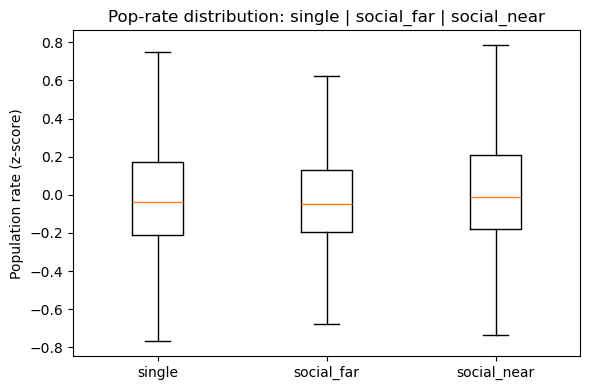

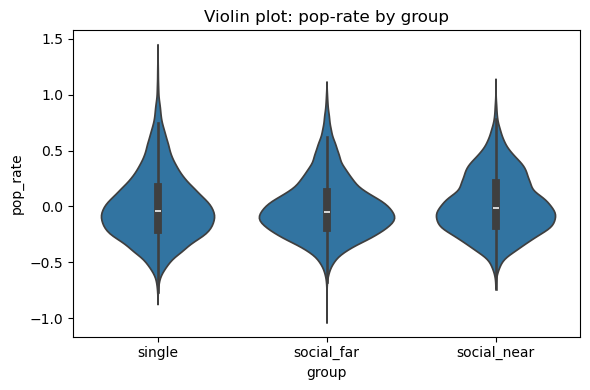

Kruskal–Wallis H = 93.249, p = 5.641e-21
  single vs social_far → U = 248337019.0, p = 1.085e-01
  single vs social_near → U = 105988319.0, p = 1.515e-16
  social_far vs social_near → U = 72042363.0, p = 6.186e-22

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/:


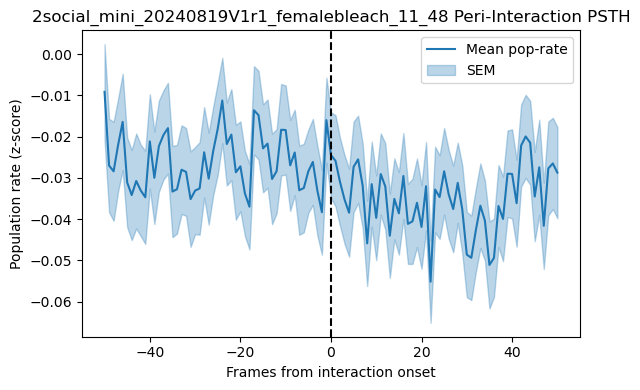


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/:


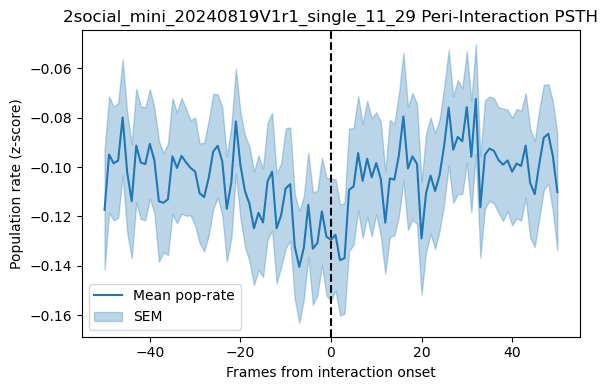


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/:


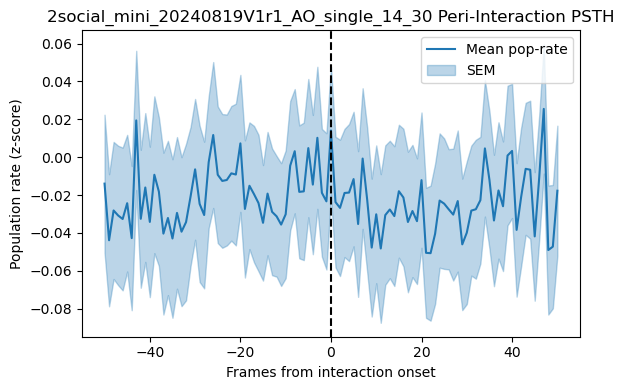


Analysis complete.


In [29]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3. Process and aggregate "social" vs "single" sessions using CSV + manual threshold
# ----------------------------------------------------------------------------
def collect_groups(session_paths, distance_threshold=250.0):
    """
    Given a list of session_paths, determine for each whether it is social (>=2 COM prefixes) or single ('com_x' exists).
    For social sessions, load 'com_distances_filtered.csv', which must contain at least two columns:
      - A frame index column (e.g. 'camera_frame_sixcam')
      - A distance column (e.g. 'distance')
    Use distance_threshold (e.g., 250.0) to split frames into 'social near' (distance <= threshold) vs 'social far'.

    Collect pop_rate into:
      - all_pop_single
      - all_pop_social_near
      - all_pop_social_far

    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single      = []
    all_pop_social_near = []
    all_pop_social_far  = []
    social_onsets_dict  = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Determine session type by checking for COM prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        is_social = len(com_prefixes) >= 2
        is_single = all(k in df_new.columns for k in ['com_x', 'com_y', 'com_z'])

        if is_social:
            # Load filtered distances CSV
            com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
            if not os.path.exists(com_csv_path):
                print(f"  Skipping (social): Missing {com_csv_path}")
                continue

            df_com = pd.read_csv(com_csv_path)
            if df_com.shape[1] < 2:
                raise KeyError(
                    "com_distances_filtered.csv must contain at least two columns: "
                    "frame index (e.g. 'camera_frame_sixcam') and 'distance'."
                )

            # Assume first column is frame index, second column is distance
            frame_col = df_com.columns[0]
            dist_col  = df_com.columns[1]
            df_com[frame_col] = df_com[frame_col].astype(int)
            df_com[dist_col]  = df_com[dist_col].astype(float)

            # Ensure 'camera_frame_sixcam' exists in HDF5
            if 'camera_frame_sixcam' not in df_new.columns:
                print(f"  Skipping (social): Missing 'camera_frame_sixcam' in HDF5")
                continue

            # Merge HDF5 rows with CSV distances by frame index
            merged = pd.merge(
                df_new[['camera_frame_sixcam', 'timestamp_ms_mini']].reset_index(drop=True),
                df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
                on='camera_frame_sixcam',
                how='left'
            )
            # 'merged' now has columns ['camera_frame_sixcam', 'timestamp_ms_mini', 'distance']
            # Frames without a match in CSV get NaN distance → treat them as far
            distances = merged['distance'].fillna(distance_threshold + 1.0).values
            timestamps = merged['timestamp_ms_mini'].values

            # Create boolean masks
            near_mask = distances <= distance_threshold
            far_mask  = distances > distance_threshold

            # Collect pop_rate split by masks
            all_pop_social_near += pop_rate[near_mask].tolist()
            all_pop_social_far  += pop_rate[far_mask].tolist()

            # Detect onsets (far → near transitions)
            labels = np.where(near_mask, 'near', 'far')
            onsets = np.where((labels[:-1] == 'far') & (labels[1:] == 'near'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif is_single:
            # Single session: collect all pop_rate values
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing/insufficient 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_near, all_pop_social_far, social_onsets_dict

# ----------------------------------------------------------------------------
# 4. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_near, pop_far):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_far
      - social_near

    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests.
    """
    data   = [pop_single, pop_far, pop_near]
    labels = ['single', 'social_far', 'social_near']

    # Filter out empty groups
    nonempty_data   = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_far | social_near")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_far), len(pop_near)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_far, pop_near)
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests
    pairs = [
        ('single',    pop_single, 'social_far',  pop_far),
        ('single',    pop_single, 'social_near', pop_near),
        ('social_far',pop_far,    'social_near', pop_near)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            u_stat, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            print(f"  {a_name} vs {b_name} → U = {u_stat:.1f}, p = {p_u:.3e}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 5. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    session_paths = [
        # Social sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # Single sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"
    ]

    # Use a fixed distance threshold of 250 for splitting near vs far
    threshold = 250.0

    # Collect three groups of pop_rate and social event onsets
    pop_single, pop_near, pop_far, social_onsets_dict = collect_groups(session_paths, distance_threshold=threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_far = {len(pop_far)}, social_near = {len(pop_near)}\n")

    # Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_near, pop_far)

    # Optional: Plot Peri-Event PSTH for each social session
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)

    print("\nAnalysis complete.")


Collected 211 social-far points and 211 social-close points.


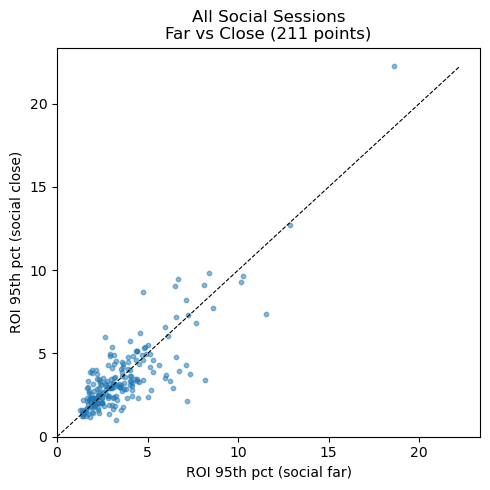

Collected 292 single-session ROI points.


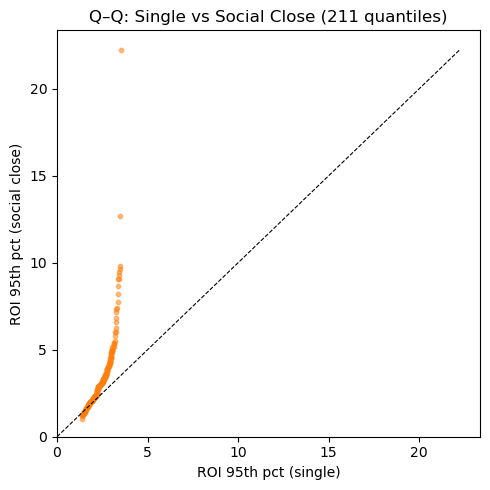

Done.


In [30]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 从 CSV 读取每帧的 distance，并合并 HDF5 的 camera_frame_sixcam 来对齐
      3. 根据 threshold 分类成 far_mask (distance > threshold) 和 close_mask (distance <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
    if not os.path.exists(com_csv_path):
        raise FileNotFoundError(f"Missing {com_csv_path}")

    df_com = pd.read_csv(com_csv_path)
    if df_com.shape[1] < 2:
        raise KeyError("com_distances_filtered.csv must contain at least two columns: "
                       "frame index and distance")

    frame_col = df_com.columns[0]
    dist_col  = df_com.columns[1]
    df_com[frame_col] = df_com[frame_col].astype(int)
    df_com[dist_col]  = df_com[dist_col].astype(float)

    if 'camera_frame_sixcam' not in df.columns:
        raise KeyError("HDF5 must contain 'camera_frame_sixcam' column for merging")

    merged = pd.merge(
        df[['camera_frame_sixcam']].reset_index(drop=True),
        df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
        on='camera_frame_sixcam',
        how='left'
    )
    distances = merged[dist_col].fillna(threshold + 1.0).values

    close_mask = distances <= threshold
    far_mask   = distances > threshold

    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 3b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4a. 聚合所有 social session 的 far & close 数据
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把每个 ROI 的 far_pct 和 close_pct 都添加到 all_far 和 all_close 列表里。
    返回：
      np.array(all_far), np.array(all_close)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            _, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

# ----------------------------------------------------------------------------
# 4b. 聚合所有 single session 的全时段 95th 数据
# ----------------------------------------------------------------------------
def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把每个 ROI 的 pct 值添加到 all_single 列表里。
    返回：
      np.array(all_single)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            _, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------
# 5. 可视化
#    (A) Social Far vs Social Close 散点图 (聚合所有 session)
#    (B) Single vs Social Close Q–Q 样式散点图 (95th percentile)
# ----------------------------------------------------------------------------
def plot_social_far_close_scatter(all_far, all_close):
    """
    画一张 scatter：横轴 = social far (95th)，纵轴 = social close (95th)。
    点来自所有 social session 的所有 ROI。
    """
    if all_far.size == 0 or all_close.size == 0:
        print("No social far/close data to plot.")
        return

    global_max = np.nanmax(np.concatenate([all_far, all_close]))
    plt.figure(figsize=(5, 5))
    plt.scatter(all_far, all_close, s=10, alpha=0.5)
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Social Sessions\nFar vs Close ({len(all_far)} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_qq(all_single, all_close):
    """
    用 Q–Q 样式的方法对比两个分布：
      - all_single: 所有 single sessions 的 ROI 95th pct
      - all_close:  所有 social close 的 ROI 95th pct
    方法：排序后按 index 一一对应，绘制 scatter。
    """
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close Q–Q plot.")
        return

    sorted_single = np.sort(all_single)
    sorted_close  = np.sort(all_close)
    n = min(len(sorted_single), len(sorted_close))
    x = sorted_single[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C1')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Single vs Social Close ({n} quantiles)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. 示例执行
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数

    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    single_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    ]

    all_far, all_close = aggregate_social_far_close(social_sessions, exclude_mapping, threshold, pct)
    print(f"Collected {len(all_far)} social-far points and {len(all_close)} social-close points.")
    plot_social_far_close_scatter(all_far, all_close)

    all_single = aggregate_single_stats(single_sessions, exclude_mapping, pct)
    print(f"Collected {len(all_single)} single-session ROI points.")
    plot_single_vs_social_close_qq(all_single, all_close)

    print("Done.")


Collected 55 social-far points and 55 social-close points.


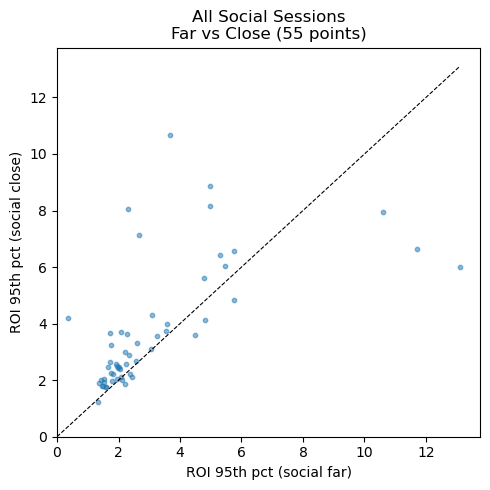

Collected 309 single-session ROI points.


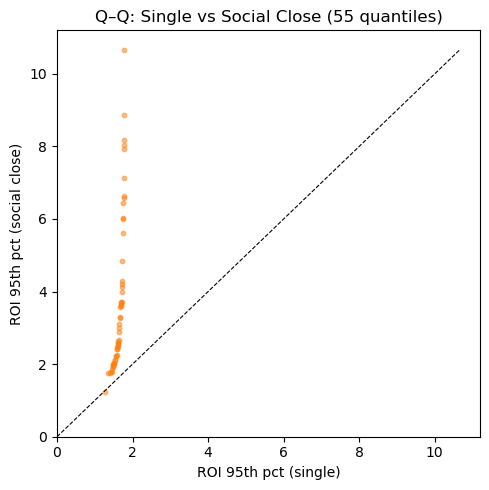

Done.


In [35]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 从 CSV 读取每帧的 distance，并合并 HDF5 的 camera_frame_sixcam 来对齐
      3. 根据 threshold 分类成 far_mask (distance > threshold) 和 close_mask (distance <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
    if not os.path.exists(com_csv_path):
        raise FileNotFoundError(f"Missing {com_csv_path}")

    df_com = pd.read_csv(com_csv_path)
    if df_com.shape[1] < 2:
        raise KeyError("com_distances_filtered.csv must contain at least two columns: "
                       "frame index and distance")

    frame_col = df_com.columns[0]
    dist_col  = df_com.columns[1]
    df_com[frame_col] = df_com[frame_col].astype(int)
    df_com[dist_col]  = df_com[dist_col].astype(float)

    if 'camera_frame_sixcam' not in df.columns:
        raise KeyError("HDF5 must contain 'camera_frame_sixcam' column for merging")

    merged = pd.merge(
        df[['camera_frame_sixcam']].reset_index(drop=True),
        df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
        on='camera_frame_sixcam',
        how='left'
    )
    distances = merged[dist_col].fillna(threshold + 1.0).values

    close_mask = distances <= threshold
    far_mask   = distances > threshold

    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 3b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4a. 聚合所有 social session 的 far & close 数据
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把每个 ROI 的 far_pct 和 close_pct 都添加到 all_far 和 all_close 列表里。
    返回：
      np.array(all_far), np.array(all_close)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            _, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

# ----------------------------------------------------------------------------
# 4b. 聚合所有 single session 的全时段 95th 数据
# ----------------------------------------------------------------------------
def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把每个 ROI 的 pct 值添加到 all_single 列表里。
    返回：
      np.array(all_single)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            _, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------
# 5. 可视化
#    (A) Social Far vs Social Close 散点图 (聚合所有 session)
#    (B) Single vs Social Close Q–Q 样式散点图 (95th percentile)
# ----------------------------------------------------------------------------
def plot_social_far_close_scatter(all_far, all_close):
    """
    画一张 scatter：横轴 = social far (95th)，纵轴 = social close (95th)。
    点来自所有 social session 的所有 ROI。
    """
    if all_far.size == 0 or all_close.size == 0:
        print("No social far/close data to plot.")
        return

    global_max = np.nanmax(np.concatenate([all_far, all_close]))
    plt.figure(figsize=(5, 5))
    plt.scatter(all_far, all_close, s=10, alpha=0.5)
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Social Sessions\nFar vs Close ({len(all_far)} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_qq(all_single, all_close):
    """
    用 Q–Q 样式的方法对比两个分布：
      - all_single: 所有 single sessions 的 ROI 95th pct
      - all_close:  所有 social close 的 ROI 95th pct
    方法：排序后按 index 一一对应，绘制 scatter。
    """
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close Q–Q plot.")
        return

    sorted_single = np.sort(all_single)
    sorted_close  = np.sort(all_close)
    n = min(len(sorted_single), len(sorted_close))
    x = sorted_single[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C1')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Single vs Social Close ({n} quantiles)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. 示例执行
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数

    social_sessions = [
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",


            "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",
    ]

    single_sessions = [
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",

            "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240910V1r_AO_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"
    ]

    # session_paths = [
    #     # Social sessions
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_1
        

    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",


    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
    #     # Single sessions
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
    #     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"


    # #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240910V1r_AO_12_50",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    # # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"

    # ]

    all_far, all_close = aggregate_social_far_close(social_sessions, exclude_mapping, threshold, pct)
    print(f"Collected {len(all_far)} social-far points and {len(all_close)} social-close points.")
    plot_social_far_close_scatter(all_far, all_close)

    all_single = aggregate_single_stats(single_sessions, exclude_mapping, pct)
    print(f"Collected {len(all_single)} single-session ROI points.")
    plot_single_vs_social_close_qq(all_single, all_close)

    print("Done.")


Collected 211 social-far points and 211 social-close points.
Collected 292 single-session ROI points.


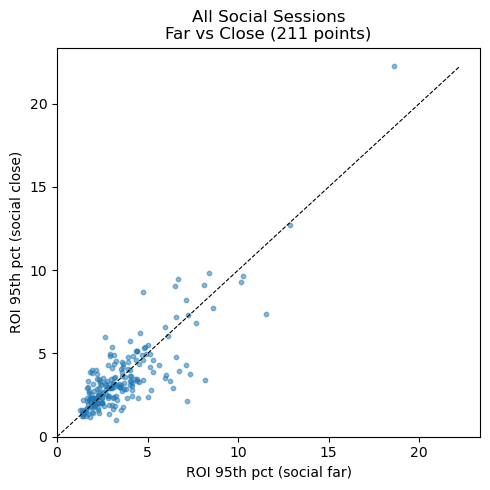

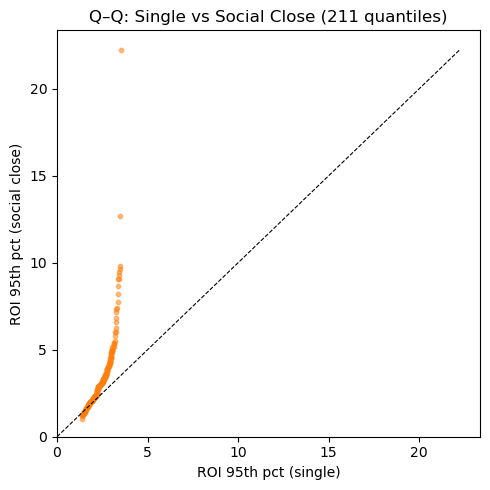

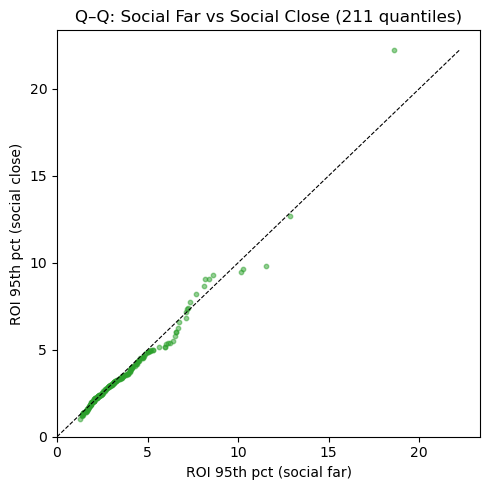

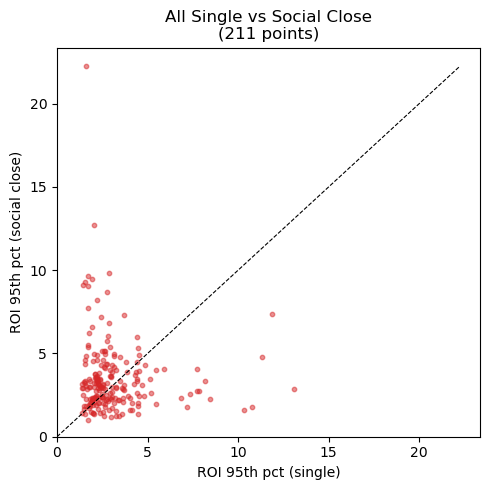

Done.


In [37]:
#!/usr/bin/env python3
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 从 CSV 读取每帧的 distance，并合并 HDF5 的 camera_frame_sixcam 来对齐
      3. 根据 threshold 分类成 far_mask (distance > threshold) 和 close_mask (distance <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
    if not os.path.exists(com_csv_path):
        raise FileNotFoundError(f"Missing {com_csv_path}")

    df_com = pd.read_csv(com_csv_path)
    if df_com.shape[1] < 2:
        raise KeyError("com_distances_filtered.csv must contain at least two columns: "
                       "frame index and distance")

    frame_col = df_com.columns[0]
    dist_col  = df_com.columns[1]
    df_com[frame_col] = df_com[frame_col].astype(int)
    df_com[dist_col]  = df_com[dist_col].astype(float)

    if 'camera_frame_sixcam' not in df.columns:
        raise KeyError("HDF5 must contain 'camera_frame_sixcam' column for merging")

    merged = pd.merge(
        df[['camera_frame_sixcam']].reset_index(drop=True),
        df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
        on='camera_frame_sixcam',
        how='left'
    )
    distances = merged[dist_col].fillna(threshold + 1.0).values

    close_mask = distances <= threshold
    far_mask   = distances > threshold

    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 3b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4a. 聚合所有 social session 的 far & close 数据
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把每个 ROI 的 far_pct 和 close_pct 都添加到 all_far 和 all_close 列表里。
    返回：
      np.array(all_far), np.array(all_close)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            _, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

# ----------------------------------------------------------------------------
# 4b. 聚合所有 single session 的全时段 95th 数据
# ----------------------------------------------------------------------------
def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把每个 ROI 的 pct 值添加到 all_single 列表里。
    返回：
      np.array(all_single)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            _, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------
# 5. 可视化
#    (A) Social Far vs Social Close 散点图 (聚合所有 session)
#    (B) Single vs Social Close Q–Q 样式散点图 (95th percentile)
#    (C) Social Far vs Social Close Q–Q 样式散点图 (95th percentile)
#    (D) Single vs Social Close 散点图 (聚合所有 session)
# ----------------------------------------------------------------------------
def plot_social_far_close_scatter(all_far, all_close):
    """
    画一张 scatter：横轴 = social far (95th)，纵轴 = social close (95th)。
    点来自所有 social session 的所有 ROI。
    """
    if all_far.size == 0 or all_close.size == 0:
        print("No social far/close data to plot.")
        return

    global_max = np.nanmax(np.concatenate([all_far, all_close]))
    plt.figure(figsize=(5, 5))
    plt.scatter(all_far, all_close, s=10, alpha=0.5)
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Social Sessions\nFar vs Close ({len(all_far)} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_qq(all_single, all_close):
    """
    用 Q–Q 样式的方法对比两个分布：
      - all_single: 所有 single sessions 的 ROI 95th pct
      - all_close:  所有 social close 的 ROI 95th pct
    方法：排序后按 index 一一对应，绘制 scatter。
    """
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close Q–Q plot.")
        return

    sorted_single = np.sort(all_single)
    sorted_close  = np.sort(all_close)
    n = min(len(sorted_single), len(sorted_close))
    x = sorted_single[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C1')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Single vs Social Close ({n} quantiles)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_social_far_close_qq(all_far, all_close):
    """
    用 Q–Q 样式的方法对比两个分布：
      - all_far:   所有 social far 的 ROI 95th pct
      - all_close: 所有 social close 的 ROI 95th pct
    方法：排序后按 index 一一对应，绘制 scatter。
    """
    if all_far.size == 0 or all_close.size == 0:
        print("No data for Social Far vs Social Close Q–Q plot.")
        return

    sorted_far   = np.sort(all_far)
    sorted_close = np.sort(all_close)
    n = min(len(sorted_far), len(sorted_close))
    x = sorted_far[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C2')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Social Far vs Social Close ({n} quantiles)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_scatter(all_single, all_close):
    """
    画一张 scatter：横轴 = single (95th)，纵轴 = social close (95th)。
    点来自所有 single session 和所有 social-close ROI 值。
    要求：x 和 y 必须同长度，故取最小公共长度后再绘图。
    """
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close scatter plot.")
        return

    # 取最小公共长度
    n = min(len(all_single), len(all_close))
    x = all_single[:n]
    y = all_close[:n]

    global_max = np.nanmax(np.concatenate([x, y]))
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C3')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Single vs Social Close\n({n} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------------
# 6. 示例执行
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数

    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    single_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    ]

    # 收集 social far & social close 数据
    all_far, all_close = aggregate_social_far_close(social_sessions, exclude_mapping, threshold, pct)
    print(f"Collected {len(all_far)} social-far points and {len(all_close)} social-close points.")

    # 收集 single-session 数据
    all_single = aggregate_single_stats(single_sessions, exclude_mapping, pct)
    print(f"Collected {len(all_single)} single-session ROI points.")

    # 原有的 plot
    plot_social_far_close_scatter(all_far, all_close)
    plot_single_vs_social_close_qq(all_single, all_close)

    # 新增：social far vs social close 的 Q–Q plot
    plot_social_far_close_qq(all_far, all_close)

    # 新增：single vs social close 的 scatter plot
    # 注意：如果 all_single 长度大于 all_close，需要确保配对时不越界
    if len(all_close) < len(all_single):
        print("Warning: fewer social-close points than single points; plotting up to min length.")
    plot_single_vs_social_close_scatter(all_single, all_close)

    print("Done.")


In [44]:
#!/usr/bin/env python3
"""
Standalone script to compute descriptive statistics and p-values for V1 and PMC ROI 95th-percentile comparisons:
 1. Social Far vs Social Close (paired)
 2. Single vs Social Close (unpaired)
 3. Single vs Social Far   (unpaired)

Usage:
    python3 compute_v1_pmc_stats.py
"""

import os
import json
import glob
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions (same as your graph script)
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 2a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 从 CSV 读取每帧的 distance，并合并 HDF5 的 camera_frame_sixcam 来对齐
      3. 根据 threshold 分类成 far_mask (distance > threshold) 和 close_mask (distance <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
    if not os.path.exists(com_csv_path):
        raise FileNotFoundError(f"Missing {com_csv_path}")

    df_com = pd.read_csv(com_csv_path)
    if df_com.shape[1] < 2:
        raise KeyError("com_distances_filtered.csv 必须包含至少两列：帧索引和距离")

    frame_col = df_com.columns[0]
    dist_col  = df_com.columns[1]
    df_com[frame_col] = df_com[frame_col].astype(int)
    df_com[dist_col]  = df_com[dist_col].astype(float)

    if 'camera_frame_sixcam' not in df.columns:
        raise KeyError("HDF5 必须包含 'camera_frame_sixcam' 列以便合并")

    merged = pd.merge(
        df[['camera_frame_sixcam']].reset_index(drop=True),
        df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
        on='camera_frame_sixcam',
        how='left'
    )
    distances = merged[dist_col].fillna(threshold + 1.0).values

    close_mask = distances <= threshold
    far_mask   = distances > threshold

    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 2b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 3a. 聚合所有 social session 的 far & close 数据
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把每个 ROI 的 far_pct 和 close_pct 都添加到 all_far 和 all_close 列表里。
    返回：
      np.array(all_far), np.array(all_close)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            _, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

# ----------------------------------------------------------------------------
# 3b. 聚合所有 single session 的全时段 95th 数据
# ----------------------------------------------------------------------------
def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把每个 ROI 的 pct 值添加到 all_single 列表里。
    返回：
      np.array(all_single)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            _, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------


# ----------------------------------------------------------------------------

# （示例路径，只做示范，请根据自己目录实际修改）
pmc_social_sessions = [
  
            "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
"/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",
  
]

pmc_single_sessions = [
   "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
     "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"
]

v1_social_sessions = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",

]

v1_single_sessions = [
 "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
  
]

# ----------------------------------------------------------------------------
# 5. 统计与 p 值计算
# ----------------------------------------------------------------------------
def compute_and_print_stats(label, all_far, all_close, all_single):
    """
    1. 对 Social Far vs Social Close 做配对的 Wilcoxon signed-rank 检验
    2. 对 Single vs Social Close 做 Mann-Whitney U 检验（两独立样本）
    3. 对 Single vs Social Far   做 Mann-Whitney U 检验
    并打印均值、标准差、中位数和 p 值。
    """
    # 5.1 描述性统计
    def desc_stats(arr):
        return {
            'mean': np.nanmean(arr),
            'std':  np.nanstd(arr),
            'median': np.nanmedian(arr),
            'n':    np.count_nonzero(~np.isnan(arr))
        }

    stats_far   = desc_stats(all_far)
    stats_close = desc_stats(all_close)
    stats_single= desc_stats(all_single)

    print(f"\n===== {label} =====")
    print(f"Social-Far:    n={stats_far['n']}, mean={stats_far['mean']:.3f}, std={stats_far['std']:.3f}, median={stats_far['median']:.3f}")
    print(f"Social-Close:  n={stats_close['n']}, mean={stats_close['mean']:.3f}, std={stats_close['std']:.3f}, median={stats_close['median']:.3f}")
    print(f"Single:        n={stats_single['n']}, mean={stats_single['mean']:.3f}, std={stats_single['std']:.3f}, median={stats_single['median']:.3f}")

    # 5.2 社交 Far vs Close（配对 Wilcoxon）
    if len(all_far) == len(all_close) and len(all_far) > 0:
        w_stat, w_p = wilcoxon(all_far, all_close)
        print(f"\nPaired Wilcoxon (Far vs Close): statistic={w_stat:.3f}, p-value={w_p:.5f}")
    else:
        print("\nPaired Wilcoxon (Far vs Close): 数据长度不匹配或无有效数据，无法进行配对检验。")

    # 5.3 Single vs Social Close（Mann-Whitney U, unpaired）
    if len(all_single) > 0 and len(all_close) > 0:
        u_stat_sc, u_p_sc = mannwhitneyu(all_single, all_close, alternative='two-sided')
        print(f"Mann-Whitney U (Single vs Close): U={u_stat_sc:.3f}, p-value={u_p_sc:.5f}")
    else:
        print("Mann-Whitney U (Single vs Close): 数据不足，无法进行检验。")

    # 5.4 Single vs Social Far（Mann-Whitney U, unpaired）
    if len(all_single) > 0 and len(all_far) > 0:
        u_stat_sf, u_p_sf = mannwhitneyu(all_single, all_far, alternative='two-sided')
        print(f"Mann-Whitney U (Single vs Far): U={u_stat_sf:.3f}, p-value={u_p_sf:.5f}")
    else:
        print("Mann-Whitney U (Single vs Far): 数据不足，无法进行检验.")

# ----------------------------------------------------------------------------
# 6. 主流程
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0  # COM 距离阈值
    pct = 95           # 使用第 95 百分位数

    # --- PMC 统计 ---
    print("=== PMC 统计 ===")
    pmc_far, pmc_close = aggregate_social_far_close(pmc_social_sessions, exclude_mapping, threshold, pct)
    pmc_single        = aggregate_single_stats(pmc_single_sessions, exclude_mapping, pct)
    compute_and_print_stats("PMC (Social vs Single)", pmc_far, pmc_close, pmc_single)

    # --- V1 统计 ---
    print("\n=== V1 统计 ===")
    v1_far, v1_close  = aggregate_social_far_close(v1_social_sessions, exclude_mapping, threshold, pct)
    v1_single         = aggregate_single_stats(v1_single_sessions, exclude_mapping, pct)
    compute_and_print_stats("V1 (Social vs Single)", v1_far, v1_close, v1_single)

    print("\n所有统计计算完毕。")


=== PMC 统计 ===

===== PMC (Social vs Single) =====
Social-Far:    n=55, mean=3.132, std=2.453, median=2.227
Social-Close:  n=55, mean=3.724, std=2.154, median=2.887
Single:        n=294, mean=2.944, std=1.619, median=2.473

Paired Wilcoxon (Far vs Close): statistic=312.000, p-value=0.00012
Mann-Whitney U (Single vs Close): U=6316.000, p-value=0.01002
Mann-Whitney U (Single vs Far): U=8923.000, p-value=0.22265

=== V1 统计 ===

===== V1 (Social vs Single) =====
Social-Far:    n=211, mean=3.573, std=2.179, median=3.021
Social-Close:  n=211, mean=3.504, std=2.257, median=2.977
Single:        n=292, mean=3.183, std=1.719, median=2.717

Paired Wilcoxon (Far vs Close): statistic=10962.000, p-value=0.80344
Mann-Whitney U (Single vs Close): U=28163.000, p-value=0.10045
Mann-Whitney U (Single vs Far): U=27888.000, p-value=0.06973

所有统计计算完毕。


In [43]:
print("mat_raw:", mat_raw.shape)             # (n_kept, n_frames)
print("far_mask:", far_mask.shape, far_mask.sum(), "frames")  # (n_frames,), True 数量就是 n_far_frames
print("mat_raw[:, far_mask]:", mat_raw[:, far_mask].shape)   # (n_kept, n_far_frames)


NameError: name 'mat_raw' is not defined

Collected 211 social-far points and 211 social-close points.
Collected 292 single-session ROI points.


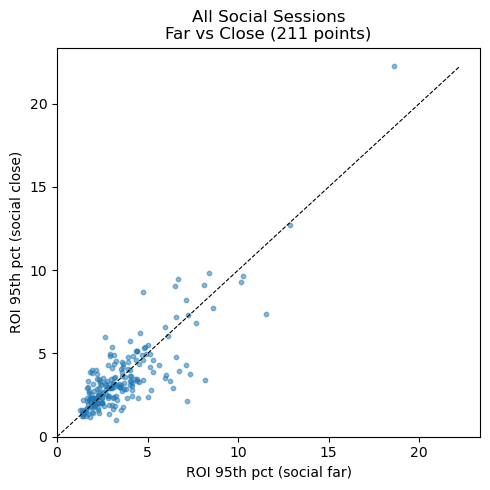

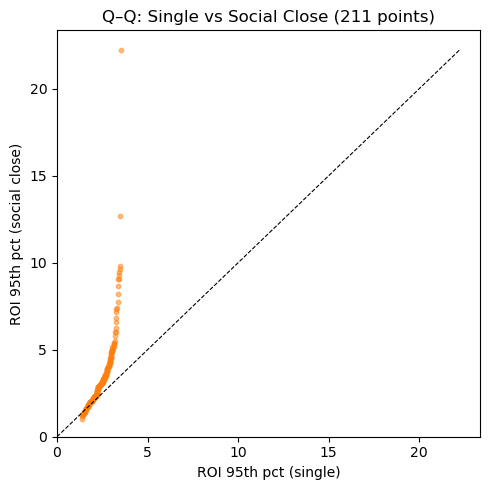

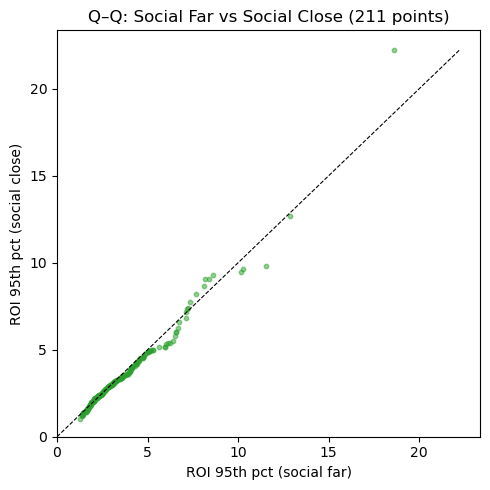

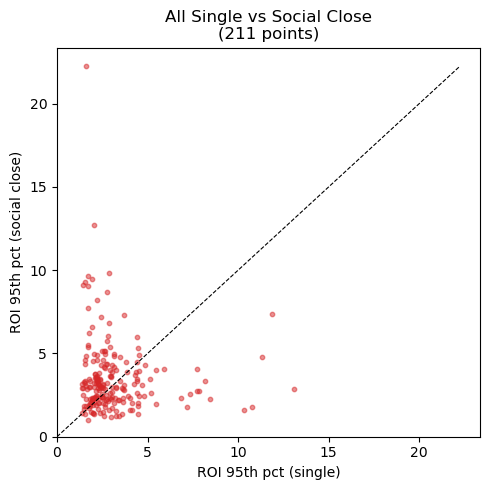

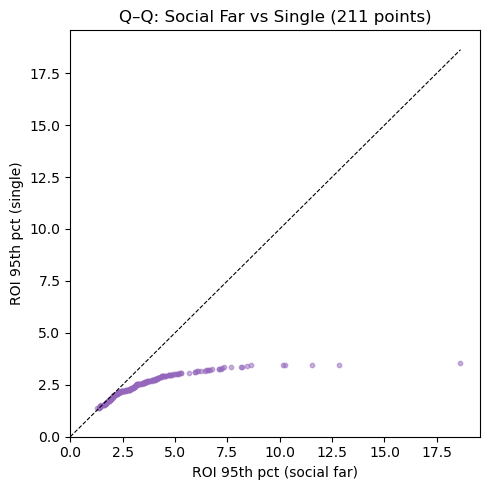

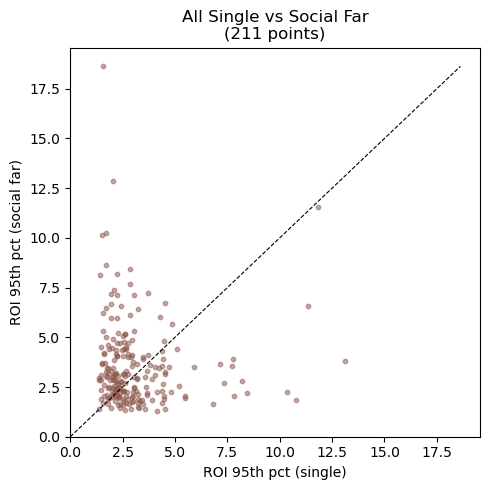

Done.


In [38]:
#!/usr/bin/env python3
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加 session_path。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df['session_path'] = rec_path
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3a. 获取 social session 中每个 ROI 在 far/close 片段的 95th percentile
# ----------------------------------------------------------------------------
def get_social_far_close_stats(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 从 CSV 读取每帧的 distance，并合并 HDF5 的 camera_frame_sixcam 来对齐
      3. 根据 threshold 分类成 far_mask (distance > threshold) 和 close_mask (distance <= threshold)
      4. 对每个 ROI（行），分别计算 raw dF/F 在 far 和 close 片段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_far:   numpy array of shape (n_kept,)
      stat_close: numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
    if not os.path.exists(com_csv_path):
        raise FileNotFoundError(f"Missing {com_csv_path}")

    df_com = pd.read_csv(com_csv_path)
    if df_com.shape[1] < 2:
        raise KeyError("com_distances_filtered.csv must contain at least two columns: "
                       "frame index and distance")

    frame_col = df_com.columns[0]
    dist_col  = df_com.columns[1]
    df_com[frame_col] = df_com[frame_col].astype(int)
    df_com[dist_col]  = df_com[dist_col].astype(float)

    if 'camera_frame_sixcam' not in df.columns:
        raise KeyError("HDF5 must contain 'camera_frame_sixcam' column for merging")

    merged = pd.merge(
        df[['camera_frame_sixcam']].reset_index(drop=True),
        df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
        on='camera_frame_sixcam',
        how='left'
    )
    distances = merged[dist_col].fillna(threshold + 1.0).values

    close_mask = distances <= threshold
    far_mask   = distances > threshold

    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 3b. 获取 single session 中每个 ROI 在全时段的 95th percentile
# ----------------------------------------------------------------------------
def get_single_stats(rec_path, exclude_dict, pct=95):
    """
    对一个 single session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 对每个 ROI（行），计算 raw dF/F 在全时段中的第 pct 百分位数
    返回：
      roi_names: list[str]
      stat_all:   numpy array of shape (n_kept,)
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([])
    stat_all = np.nanpercentile(mat_raw, pct, axis=1)
    return roi_names, stat_all

# ----------------------------------------------------------------------------
# 4a. 聚合所有 social session 的 far & close 数据
# ----------------------------------------------------------------------------
def aggregate_social_far_close(social_sessions, exclude_dict, threshold=250.0, pct=95):
    """
    对一组 social_sessions，循环调用 get_social_far_close_stats，
    把每个 ROI 的 far_pct 和 close_pct 都添加到 all_far 和 all_close 列表里。
    返回：
      np.array(all_far), np.array(all_close)
    """
    all_far = []
    all_close = []

    for rec_path in social_sessions:
        try:
            _, stat_far, stat_close = get_social_far_close_stats(rec_path, exclude_dict, threshold, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_far) & ~np.isnan(stat_close)
        all_far.extend(stat_far[valid_idx].tolist())
        all_close.extend(stat_close[valid_idx].tolist())

    return np.array(all_far), np.array(all_close)

# ----------------------------------------------------------------------------
# 4b. 聚合所有 single session 的全时段 95th 数据
# ----------------------------------------------------------------------------
def aggregate_single_stats(single_sessions, exclude_dict, pct=95):
    """
    对一组 single_sessions，循环调用 get_single_stats，
    把每个 ROI 的 pct 值添加到 all_single 列表里。
    返回：
      np.array(all_single)
    """
    all_single = []

    for rec_path in single_sessions:
        try:
            _, stat_all = get_single_stats(rec_path, exclude_dict, pct)
        except Exception as e:
            print(f"  Skipping {rec_path}: {e}")
            continue

        valid_idx = ~np.isnan(stat_all)
        all_single.extend(stat_all[valid_idx].tolist())

    return np.array(all_single)

# ----------------------------------------------------------------------------
# 5. 可视化
#    (A) Social Far vs Social Close 散点图 (聚合所有 session)
#    (B) Single vs Social Close Q–Q 样式散点图 (95th percentile)
#    (C) Social Far vs Social Close Q–Q 样式散点图 (95th percentile)
#    (D) Single vs Social Close 散点图 (聚合所有 session)
#    (E) Social Far vs Single Q–Q 样式散点图 (95th percentile)
#    (F) Single vs Social Far 散点图 (聚合所有 session)
# ----------------------------------------------------------------------------
def plot_social_far_close_scatter(all_far, all_close):
    if all_far.size == 0 or all_close.size == 0:
        print("No social far/close data to plot.")
        return

    global_max = np.nanmax(np.concatenate([all_far, all_close]))
    plt.figure(figsize=(5, 5))
    plt.scatter(all_far, all_close, s=10, alpha=0.5)
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Social Sessions\nFar vs Close ({len(all_far)} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_qq(all_single, all_close):
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close Q–Q plot.")
        return

    sorted_single = np.sort(all_single)
    sorted_close  = np.sort(all_close)
    n = min(len(sorted_single), len(sorted_close))
    x = sorted_single[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C1')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Single vs Social Close ({n} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_social_far_close_qq(all_far, all_close):
    if all_far.size == 0 or all_close.size == 0:
        print("No data for Social Far vs Social Close Q–Q plot.")
        return

    sorted_far   = np.sort(all_far)
    sorted_close = np.sort(all_close)
    n = min(len(sorted_far), len(sorted_close))
    x = sorted_far[:n]
    y = sorted_close[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C2')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"Q–Q: Social Far vs Social Close ({n} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_close_scatter(all_single, all_close):
    if all_single.size == 0 or all_close.size == 0:
        print("No data for Single vs Social Close scatter plot.")
        return

    n = min(len(all_single), len(all_close))
    x = all_single[:n]
    y = all_close[:n]

    global_max = np.nanmax(np.concatenate([x, y]))
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C3')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social close)")
    plt.title(f"All Single vs Social Close\n({n} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_social_far_vs_single_qq(all_far, all_single):
    """
    用 Q–Q 样式的方法对比两个分布：
      - all_far:    所有 social far 的 ROI 95th pct
      - all_single: 所有 single session 的 ROI 95th pct
    方法：排序后按 index 一一对应，绘制 scatter。
    """
    if all_far.size == 0 or all_single.size == 0:
        print("No data for Social Far vs Single Q–Q plot.")
        return

    sorted_far    = np.sort(all_far)
    sorted_single = np.sort(all_single)
    n = min(len(sorted_far), len(sorted_single))
    x = sorted_far[:n]
    y = sorted_single[:n]

    global_max = max(x.max(), y.max())
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C4')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (social far)")
    plt.ylabel("ROI 95th pct (single)")
    plt.title(f"Q–Q: Social Far vs Single ({n} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

def plot_single_vs_social_far_scatter(all_single, all_far):
    """
    画一张 scatter：横轴 = single (95th)，纵轴 = social far (95th)。
    点来自所有 single session 和所有 social-far ROI 值。
    要求：x 和 y 必须同长度，故取最小公共长度后再绘图。
    """
    if all_single.size == 0 or all_far.size == 0:
        print("No data for Single vs Social Far scatter plot.")
        return

    n = min(len(all_single), len(all_far))
    x = all_single[:n]
    y = all_far[:n]

    global_max = np.nanmax(np.concatenate([x, y]))
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=10, alpha=0.5, c='C5')
    plt.plot([0, global_max], [0, global_max], 'k--', lw=0.8)
    plt.xlabel("ROI 95th pct (single)")
    plt.ylabel("ROI 95th pct (social far)")
    plt.title(f"All Single vs Social Far\n({n} points)")
    plt.xlim(0, global_max * 1.05)
    plt.ylim(0, global_max * 1.05)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 6. 示例执行
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数

    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    single_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    ]

    # 收集 social-far & social-close 数据
    all_far, all_close = aggregate_social_far_close(social_sessions, exclude_mapping, threshold, pct)
    print(f"Collected {len(all_far)} social-far points and {len(all_close)} social-close points.")

    # 收集 single-session 数据
    all_single = aggregate_single_stats(single_sessions, exclude_mapping, pct)
    print(f"Collected {len(all_single)} single-session ROI points.")

    # 原有的 plot：social-far vs social-close 散点图
    plot_social_far_close_scatter(all_far, all_close)
    # 原有的 plot：single vs social-close Q–Q
    plot_single_vs_social_close_qq(all_single, all_close)
    # 新增：social-far vs social-close Q–Q
    plot_social_far_close_qq(all_far, all_close)
    # 原有：single vs social-close 散点图
    plot_single_vs_social_close_scatter(all_single, all_close)

    # 新增：social-far vs single Q–Q
    plot_social_far_vs_single_qq(all_far, all_single)
    # 新增：single vs social-far 散点图
    plot_single_vs_social_far_scatter(all_single, all_far)

    print("Done.")


In [40]:
import numpy as np

# 假设已经有了：
# all_single, all_far, all_close 这三个 NumPy 数组

def print_percentiles(name, array):
    percents = [50, 75, 90, 95, 99]
    values = np.percentile(array, percents)
    print(f"--- {name} ---")
    for p, v in zip(percents, values):
        print(f"  {p}th percentile: {v:.3f}  (unit: ΔF/F)")
    print()

print_percentiles('Single', all_single)
print_percentiles('Social Far', all_far)
print_percentiles('Social Close', all_close)


--- Single ---
  50th percentile: 2.717  (unit: ΔF/F)
  75th percentile: 3.644  (unit: ΔF/F)
  90th percentile: 4.755  (unit: ΔF/F)
  95th percentile: 6.529  (unit: ΔF/F)
  99th percentile: 10.813  (unit: ΔF/F)

--- Social Far ---
  50th percentile: 3.021  (unit: ΔF/F)
  75th percentile: 4.181  (unit: ΔF/F)
  90th percentile: 6.232  (unit: ΔF/F)
  95th percentile: 7.301  (unit: ΔF/F)
  99th percentile: 11.425  (unit: ΔF/F)

--- Social Close ---
  50th percentile: 2.977  (unit: ΔF/F)
  75th percentile: 4.045  (unit: ΔF/F)
  90th percentile: 5.412  (unit: ΔF/F)
  95th percentile: 7.554  (unit: ΔF/F)
  99th percentile: 9.802  (unit: ΔF/F)



In [41]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# --------------------------------------------------------------------------------
# 假设你已经有：
#   all_single, all_far, all_close  这三个 NumPy 数组
# 它们分别是三个条件下 "每个 ROI 的 95th 百分位 ΔF/F" 的集合
# 例如：
# all_single = np.array([...])
# all_far    = np.array([...])
# all_close  = np.array([...])
# --------------------------------------------------------------------------------

# 如果你还没有这些数组，可以先用前面示例脚本生成它们，再运行下面的代码。

# 1) 先生成 0%–100%（step=1%）的分位数表
percentile_levels = np.arange(0, 101, 1)  # 0%,1%,2%,...,100%

percs_single = np.percentile(all_single, percentile_levels)
percs_far    = np.percentile(all_far,    percentile_levels)
percs_close  = np.percentile(all_close,  percentile_levels)

# 把结果放在一个 DataFrame 里，方便查看
df_percs = pd.DataFrame({
    'percentile (%)': percentile_levels,
    'Single': percs_single,
    'Social Far': percs_far,
    'Social Close': percs_close,
})
# 增加几列，显示两两之间在同一 percentile 位置的差值
df_percs['Far − Single']  = df_percs['Social Far']  - df_percs['Single']
df_percs['Close − Single']= df_percs['Social Close'] - df_percs['Single']
df_percs['Far − Close']   = df_percs['Social Far']  - df_percs['Social Close']

# 2) 计算并打印前 5 个分位（0%–4%）和后 5 个分位（96%–100%），见证极值处的差异
print("=== 分位数对比（0%–4% 和 96%–100%） ===")
print(df_percs.loc[df_percs['percentile (%)'].isin([0,1,2,3,4,96,97,98,99,100])])
print("\n")

# 3) 计算所有分位差值的统计摘要，比如最小、最大、平均、标准差，快速看看三者之间差异到底多大
diff_stats = {
    'Far − Single': {
        'min': df_percs['Far − Single'].min(),
        'max': df_percs['Far − Single'].max(),
        'mean': df_percs['Far − Single'].mean(),
        'std': df_percs['Far − Single'].std()
    },
    'Close − Single': {
        'min': df_percs['Close − Single'].min(),
        'max': df_percs['Close − Single'].max(),
        'mean': df_percs['Close − Single'].mean(),
        'std': df_percs['Close − Single'].std()
    },
    'Far − Close': {
        'min': df_percs['Far − Close'].min(),
        'max': df_percs['Far − Close'].max(),
        'mean': df_percs['Far − Close'].mean(),
        'std': df_percs['Far − Close'].std()
    },
}

print("=== 各分布在所有分位上差值（min, max, mean, std） ===")
for k, stats in diff_stats.items():
    print(f"{k}: min={stats['min']:.3f}, max={stats['max']:.3f}, "
          f"mean={stats['mean']:.3f}, std={stats['std']:.3f}")
print("\n")

# 4) 对三组分布分别做 KS 检验：Single vs Far, Single vs Close, Far vs Close
ks_sf = ks_2samp(all_single, all_far)
ks_sc = ks_2samp(all_single, all_close)
ks_fc = ks_2samp(all_far,    all_close)

print("=== Kolmogorov–Smirnov 检验结果 ===")
print(f"Single vs Social Far   : KS-stat={ks_sf.statistic:.4f}, p-value={ks_sf.pvalue:.4e}")
print(f"Single vs Social Close : KS-stat={ks_sc.statistic:.4f}, p-value={ks_sc.pvalue:.4e}")
print(f"Social Far vs Social Close: KS-stat={ks_fc.statistic:.4f}, p-value={ks_fc.pvalue:.4e}")
print("\n")

# 5) 如果想进一步直观对比整个分布，也可以把 DataFrame 保存下来
#    例如导出到 CSV，然后在外部查看
# df_percs.to_csv('percentile_comparison.csv', index=False)

# 如果你想只看关键的几个分位（如 50%、75%、90%、95%、99%），也可以单独打印：
key_percs = [50, 75, 90, 95, 99]
print("=== 关键分位（50%、75%、90%、95%、99%）对比 ===")
print(df_percs.set_index('percentile (%)').loc[key_percs])


=== 分位数对比（0%–4% 和 96%–100%） ===
     percentile (%)     Single  Social Far  Social Close  Far − Single  \
0                 0   1.365619    1.279778      1.017788     -0.085841   
1                 1   1.407201    1.377993      1.245349     -0.029208   
2                 2   1.463111    1.416064      1.274354     -0.047048   
3                 3   1.512053    1.431958      1.376963     -0.080094   
4                 4   1.538631    1.458481      1.388843     -0.080150   
96               96   7.469763    7.949132      8.498595      0.479369   
97               97   7.910289    8.343365      9.077335      0.433076   
98               98   8.239218    9.836429      9.450986      1.597211   
99               99  10.813261   11.424731      9.802235      0.611470   
100             100  13.111343   18.628088     22.250593      5.516745   

     Close − Single  Far − Close  
0         -0.347831     0.261990  
1         -0.161852     0.132644  
2         -0.188758     0.141710  
3         -0.

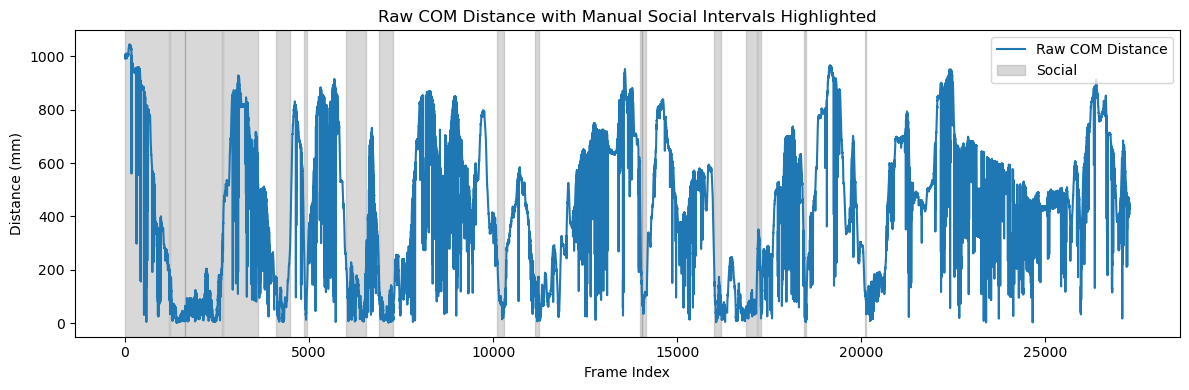


Manual intervals vs baseline distance summary:

    label  start_s  end_s  start_frame  end_frame  mean_dist  median_dist   min_dist    max_dist   std_dist  n_frames
 social_1      0.0   40.0          0.0     1200.0 628.683213   661.558338   4.823434 1045.372740 315.685332      1200
 social_2     41.0   54.0       1230.0     1620.0  36.722508    22.055001   1.829966  172.537595  36.052863       390
 social_3     54.0   88.0       1620.0     2640.0  72.073357    61.498894   4.808626  254.258798  50.900237      1020
 social_4     89.0  120.0       2670.0     3600.0 620.584235   665.447520  80.708552  928.460090 204.177769       930
 social_5    137.0  149.0       4110.0     4470.0  89.430135    73.979350   4.339612  247.649087  59.085089       360
 social_6    162.0  165.0       4860.0     4950.0 117.504565    99.202787  12.908604  304.309396  81.131940        90
 social_7    200.0  218.0       6000.0     6540.0  94.767465    89.861284   5.498568  240.267134  56.714376       540
 social

In [ ]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

def plot_raw_com_with_manual_intervals(
    base_folder,
    com_folder_name='COM/predict00',
    manual_ranges_s=None,
    fps=30,
    save_csv=True
):
    """
    从原始 COM mat 文件中载入两只动物的 (x,y,z) 数据，
    计算两者每帧的欧式距离，并在同一张图上以灰色高亮手动标注的“社交区间”（秒）。
    同时输出每个标注区间和 baseline（未标注区间）的距离统计指标。

    参数
    ----
    base_folder : str
      会话根文件夹，需包含 "{com_folder_name}/com3d0.mat"。
    com_folder_name : str, default 'COM/predict00'
      相对于 base_folder 的 COM 文件子文件夹名。
    manual_ranges_s : List[Tuple[float,float]]
      手动标注的区间列表，单位是秒。示例：
        [(0.0, 40.0), (41.0, 54.0), (54.0, 88.0), ...]
    fps : int, default 30
      视频/COM 数据的帧率，用它把秒数转换成帧索引。
    save_csv : bool, default True
      是否将统计结果保存为 CSV（路径："{base_folder}/{com_folder_name}/vis/com_manual_summary.csv"）。

    返回
    ----
    pd.DataFrame
      每个手动区间和 baseline 的距离统计：
      - label: "social_i" 或 "baseline"
      - start_s, end_s (秒；baseline 为 NaN)
      - start_frame, end_frame（帧索引）
      - mean_dist, median_dist, min_dist, max_dist, std_dist, n_frames
    """
    # 1. 加载 com3d0.mat 并 reshape
    com_mat = os.path.join(base_folder, com_folder_name, 'com3d0.mat')
    if not os.path.isfile(com_mat):
        raise FileNotFoundError(f"未找到 COM 文件: {com_mat}")

    mat = sio.loadmat(com_mat)
    if 'com' not in mat:
        raise KeyError(f"'com' 未在 {com_mat} 中找到")
    raw = mat['com']
    # reshape to (n_frames, 3, n_animals)
    if raw.ndim == 3 and raw.shape[1] == 3:
        com_data = raw
    elif raw.ndim == 2 and raw.shape[1] % 3 == 0:
        n_animals = raw.shape[1] // 3
        com_data = raw.reshape(-1, 3, n_animals)
    else:
        raise ValueError(f"Unexpected COM shape {raw.shape}")
    n_frames, _, n_animals = com_data.shape
    if n_animals < 2:
        raise ValueError("至少需要两只动物才能计算距离")

    # 2. 计算每帧的欧式距离
    a0 = com_data[:, :, 0]  # (n_frames,3)
    a1 = com_data[:, :, 1]
    dists = np.linalg.norm(a0 - a1, axis=1)  # (n_frames,)

    # 3. 根据 fps 把手动区间 (秒) → 帧区间
    manual_ranges_s = manual_ranges_s or []
    manual_ranges_frames = []
    for (start_s, end_s) in manual_ranges_s:
        start_f = int(round(start_s * fps))
        end_f   = int(round(end_s   * fps))
        # 限制在 [0, n_frames]
        start_f = max(0, min(start_f, n_frames))
        end_f   = max(0, min(end_f,   n_frames))
        if start_f >= end_f:
            continue
        manual_ranges_frames.append((start_s, end_s, start_f, end_f))

    # 4. 绘图：距离曲线 + 高亮手动区间
    frames = np.arange(n_frames)
    plt.figure(figsize=(12, 4))
    plt.plot(frames, dists, color='tab:blue', label='Raw COM Distance')
    for idx, (start_s, end_s, start_f, end_f) in enumerate(manual_ranges_frames):
        # 第一次加标签，后面就不再重复
        label = 'Social' if idx == 0 else None
        plt.axvspan(start_f, end_f, color='tab:gray', alpha=0.3, label=label)
    plt.xlabel("Frame Index")
    plt.ylabel("Distance (mm)")
    plt.title("Raw COM Distance with Manual Social Intervals Highlighted")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. 分段统计：每个手动区间和 baseline
    mask_all = np.zeros(n_frames, dtype=bool)
    summary_list = []

    # 手动区间
    for idx, (start_s, end_s, start_f, end_f) in enumerate(manual_ranges_frames):
        seg = dists[start_f:end_f]
        mask_all[start_f:end_f] = True
        summary_list.append({
            'label':       f"social_{idx+1}",
            'start_s':     start_s,
            'end_s':       end_s,
            'start_frame': start_f,
            'end_frame':   end_f,
            'mean_dist':   np.nanmean(seg),
            'median_dist': np.nanmedian(seg),
            'min_dist':    np.nanmin(seg),
            'max_dist':    np.nanmax(seg),
            'std_dist':    np.nanstd(seg),
            'n_frames':    seg.size
        })

    # baseline 区间（未标注部分）
    base_seg = dists[~mask_all]
    summary_list.append({
        'label':       'baseline',
        'start_s':     np.nan,
        'end_s':       np.nan,
        'start_frame': np.nan,
        'end_frame':   np.nan,
        'mean_dist':   np.nanmean(base_seg) if base_seg.size else np.nan,
        'median_dist': np.nanmedian(base_seg) if base_seg.size else np.nan,
        'min_dist':    np.nanmin(base_seg) if base_seg.size else np.nan,
        'max_dist':    np.nanmax(base_seg) if base_seg.size else np.nan,
        'std_dist':    np.nanstd(base_seg) if base_seg.size else np.nan,
        'n_frames':    base_seg.size
    })

    df_summary = pd.DataFrame(summary_list)
    print("\nManual intervals vs baseline distance summary:\n")
    print(df_summary.to_string(index=False))

    # 6. 保存 CSV
    if save_csv:
        vis_dir = os.path.join(base_folder, com_folder_name, 'vis')
        os.makedirs(vis_dir, exist_ok=True)
        csv_path = os.path.join(vis_dir, 'com_manual_summary.csv')
        df_summary.to_csv(csv_path, index=False)
        print(f"\n已将结果保存到：{csv_path}")

    return df_summary

# ========== 示例调用 ==========
if __name__ == '__main__':
    session_folder = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/"  # 替换为实际路径
    manual_ranges_s = [
        (0.0, 40.0),   (41.0, 54.0),  (54.0, 88.0),
        (89.0, 120.0), (137.0, 149.0), (162.0, 165.0),
        (200.0, 218.0), (230.0, 243.0), (337.0, 343.0),
        (371.0, 375.0), (466.0, 468.0), (468.0, 472.0),
        (530.0, 530.0), (533.0, 540.0), (562.0, 572.0),
        (573.0, 576.0), (615.0, 617.0), (670.0, 671.0),
    ]
    df_summary = plot_raw_com_with_manual_intervals(
        base_folder=session_folder,
        com_folder_name='COM/predict00',
        manual_ranges_s=manual_ranges_s,
        fps=30,
        # save_csv=True
    )


Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30


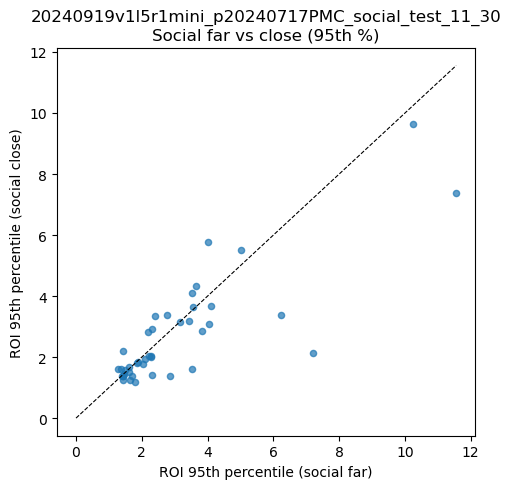

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04


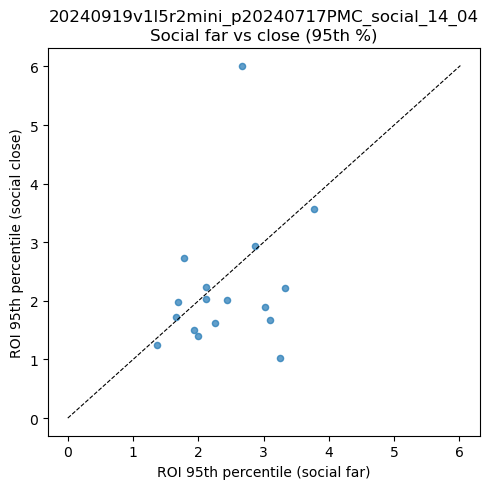

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29


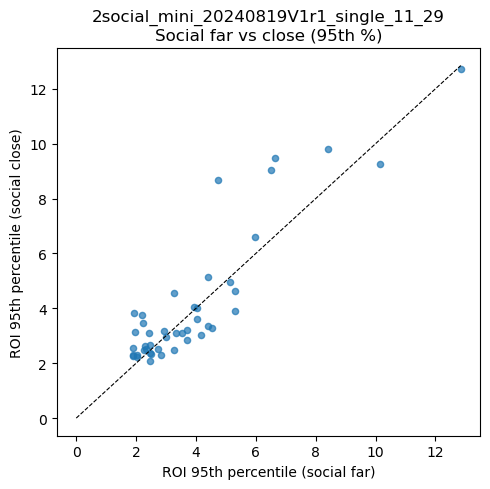

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48


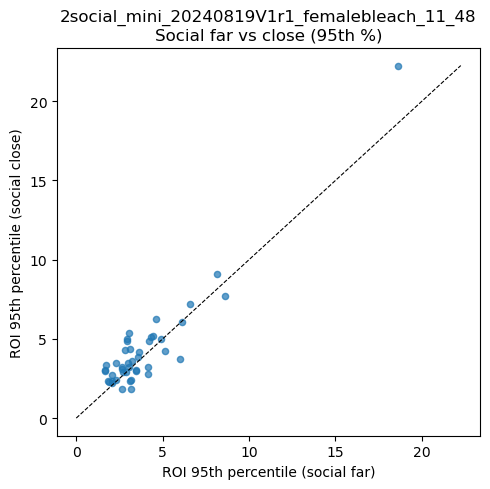

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2


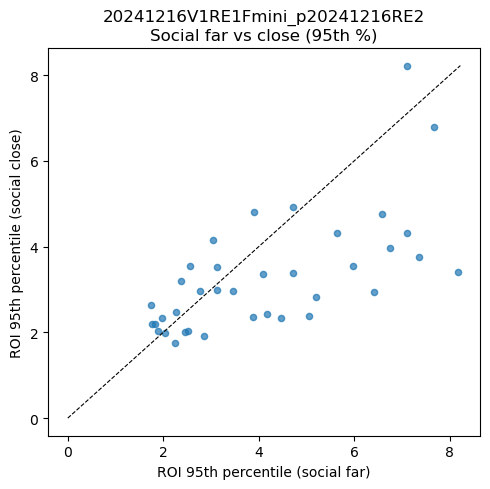

Plotting far vs close for: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1


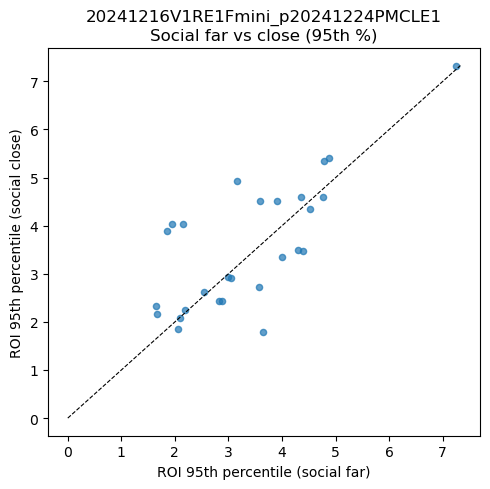

All done.


In [31]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Build neuron-by-frame matrix (raw dF/F), 排除低方差 & 排除名单
# ----------------------------------------------------------------------------
def build_neuron_matrix_raw(df, exclude_dict):
    """
    - 如果 df 的 index 名是 'timestamp_ms_mini'，先 reset_index()
    - 找到所有 dF_F_roi 列，排除 exclude_dict 指定的那些 ROI 索引
    - 计算每个 ROI 的方差，将底部 5% 的 ROI 排掉
    - 返回：kept_names (list[str]) 和 raw_matrix (numpy.ndarray, shape=(n_kept, n_frames))
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    sess = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_names = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_names = []
    for c in all_names:
        try:
            idx = int(c.split('_')[-1][3:])
        except:
            continue
        if idx not in excluded:
            keep_names.append(c)
    if not keep_names:
        return [], np.zeros((0, len(df)))
    activity = df[keep_names].values.T
    variances = np.var(activity, axis=1)
    cutoff = np.percentile(variances, 5) if variances.size else 0
    keep_mask = variances > cutoff
    kept_names = [keep_names[i] for i in range(len(keep_names)) if keep_mask[i]]
    filtered = activity[keep_mask, :]
    return kept_names, filtered

# ----------------------------------------------------------------------------
# 3. 获取 social session 中每个 ROI 在 far/close 的 summary statistic（基于 CSV）
# ----------------------------------------------------------------------------
def get_social_roi_stats_csv(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    对一个 social session：
      1. load DataFrame & build raw neuron matrix (n_kept, n_frames)
      2. 读取 'MIR_Aligned/com_distances_filtered.csv'，它应包含两列：帧索引（第一列）和距离（第二列）
      3. 将 HDF5 中的 'camera_frame_sixcam' 与 CSV 的帧索引合并，得到对齐的距离数组
      4. 根据 threshold，分类成 far_mask (distance > threshold) 和 close_mask (distance <= threshold)
      5. 对每个 ROI（行），分别计算 raw dF/F 在 far_mask 区间和 close_mask 区间的第 pct 百分位数
    返回：
      roi_names: list of ROI 列名
      stat_far:   numpy array, length = n_kept
      stat_close: numpy array, length = n_kept
    """
    df = load_session_data(rec_path)
    roi_names, mat_raw = build_neuron_matrix_raw(df, exclude_dict)
    if mat_raw.size == 0:
        return [], np.array([]), np.array([])

    com_csv_path = os.path.join(rec_path, 'MIR_Aligned', 'com_distances_filtered.csv')
    if not os.path.exists(com_csv_path):
        raise FileNotFoundError(f"Missing {com_csv_path}")

    df_com = pd.read_csv(com_csv_path)
    if df_com.shape[1] < 2:
        raise KeyError("com_distances_filtered.csv must contain at least two columns: frame index and distance")

    frame_col = df_com.columns[0]
    dist_col  = df_com.columns[1]
    df_com[frame_col] = df_com[frame_col].astype(int)
    df_com[dist_col]  = df_com[dist_col].astype(float)

    if 'camera_frame_sixcam' not in df.columns:
        raise KeyError("HDF5 must contain 'camera_frame_sixcam' column for merging")

    merged = pd.merge(
        df[['camera_frame_sixcam']].reset_index(drop=True),
        df_com[[frame_col, dist_col]].rename(columns={frame_col: 'camera_frame_sixcam'}),
        on='camera_frame_sixcam',
        how='left'
    )
    distances = merged[dist_col].fillna(threshold + 1.0).values

    close_mask = distances <= threshold
    far_mask   = distances > threshold

    if not np.any(close_mask):
        stat_close = np.zeros(len(roi_names)) + np.nan
    else:
        stat_close = np.nanpercentile(mat_raw[:, close_mask], pct, axis=1)
    if not np.any(far_mask):
        stat_far = np.zeros(len(roi_names)) + np.nan
    else:
        stat_far = np.nanpercentile(mat_raw[:, far_mask], pct, axis=1)

    return roi_names, stat_far, stat_close

# ----------------------------------------------------------------------------
# 4. 简单绘制 scatter: social far vs social close（基于 CSV）
# ----------------------------------------------------------------------------
def plot_social_far_vs_close(rec_path, exclude_dict, threshold=250.0, pct=95):
    """
    画一张 scatter：每个 ROI 的 (far_pct, close_pct)，横坐标 = social far 的 pct 百分位数，
    纵坐标 = social close 的 pct 百分位数。使用 CSV 中的距离对齐。
    """
    try:
        roi_names, sf, sc = get_social_roi_stats_csv(rec_path, exclude_dict, threshold, pct)
    except Exception as e:
        print(f"  Skipped {rec_path}: {e}")
        return

    if len(roi_names) == 0:
        print(f"No ROIs available for session: {rec_path}")
        return

    plt.figure(figsize=(5, 5))
    plt.scatter(sf, sc, s=20, alpha=0.7)
    maxval = np.nanmax(np.concatenate([sf, sc])) if sf.size or sc.size else 1
    plt.plot([0, maxval], [0, maxval], 'k--', linewidth=0.8)
    plt.xlabel(f"ROI {pct}th percentile (social far)")
    plt.ylabel(f"ROI {pct}th percentile (social close)")
    title = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{title}\nSocial far vs close ({pct}th %)")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 5. 示例执行：对多条 social session 画散点图
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    threshold = 250.0   # COM 距离阈值
    pct       = 95      # 使用第 95 百分位数

    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    ]

    for rec_path in social_sessions:
        print(f"Plotting far vs close for: {rec_path}")
        plot_social_far_vs_close(rec_path, exclude_mapping, threshold, pct)

    print("All done.")
